In [290]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time
import timeit
import h5py
import shutil
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.mixture import GaussianMixture
from sklearn import datasets, mixture

from math import ceil
from tqdm import tqdm
from collections import defaultdict
from IPython import display
from itertools import cycle, islice

import sys
sys.path.append('../../')

from evaluation import *
np.random.seed(10)
%matplotlib inline

## Сохранение/загрузка метрик

Сохраняет словарь с метриками в указанную папку с данным именем

In [291]:
def dump(saved_dict, folder, name):
    dict_for_json = {k: {kk: list(vv) for kk, vv in v.items()} if isinstance(v, dict) else list(v) 
                     for k, v in saved_dict.items()}
    with open(os.path.join(folder, name + ".json"), 'w', encoding="utf-8") as file:
        # writing
        json.dump(dict_for_json, file, indent=4, ensure_ascii=False)
    del dict_for_json

Метрики в указанной папке сохраняю в нумерованую папку(чтобы чаще дампить и удалять старые метрики + не запариваться о названиях)

Для этого первая функция возвращает последний номер из созданых папок

Вторая создает папку со следующим номером и возвращает названия новой и старой папки

In [292]:
def get_last_dir_n(metrics_path):
    try:
        last_folder_n = max(list(map(lambda name: int(name), 
                                     filter(lambda name: os.path.isdir(os.path.join(metrics_path, name)) 
                                            and name.isdecimal(), os.listdir(metrics_path)))))
    except:
        last_folder_n = 0
    return last_folder_n

def create_metrics_folder(metrics_path):
    last_folder_n = get_last_dir_n(metrics_path)
    new_folder = os.path.join(metrics_path, str(last_folder_n + 1))
    old_folder = os.path.join(metrics_path, str(last_folder_n))
    os.makedirs(new_folder)    
    return new_folder, old_folder

Костыльное сохранение метрик для supervised алгоритмов и удаление старой папки

In [293]:
def dump_metrics_sup(metrics_path):
    folder, old_folder = create_metrics_folder(metrics_path)
    print(folder)

    dump(supervised_pr_aucs, folder, "supervised_pr_aucs")
    dump(supervised_roc_aucs, folder, "supervised_roc_aucs")
    dump(supervised_p_at_10, folder, "supervised_p_at_10")
    dump(supervised_p_at_r, folder, "supervised_p_at_r")
    
    shutil.rmtree(old_folder, ignore_errors=True)
    

Загрузка метрик из указанной папки

In [294]:
def load_metrics(metrics_path):
    """
    Return
    ------
    metrics: dict, {metric_name: {clf_name: [(frac, metric_value), ...], ...}}
        frac == fraction of negative data used
    """
    metrics = {}
    folder = os.path.join(metrics_path, str(get_last_dir_n(metrics_path)))
    for file_name in filter(lambda name: name.endswith('.json'), os.listdir(folder)):
        with open(os.path.join(folder, file_name), 'r') as file:
            metrics[file_name[:-5]] = json.load(file)
    return metrics

## Построение графика

График зависимости значения метрики от доли используемых аномалий от имеющихся(1 == используем все имеющиеся аномалии)

In [295]:
def metric_boxplot(metrics, ylabel='PR_AUC', ylim=None):
    """
    Params
    ------
    metrics: dict, {clf_name: [(frac, metric_value), ...]}
        frac == fraction of negative data used
        all metric_values for one metric
    ylabel: str, name of current metric
    ylim: None or tuple, shape=(2)
        Parametr for Oy axis(metric value)
    """
    n = len(metrics.keys())
    plt.figure(figsize=(15, 7 * ceil(n/2)))

    for i, clf_name in enumerate(metrics.keys()):
        plt.subplot(ceil(n/2), 2, i + 1)
        sns.boxplot(np.array(metrics[clf_name])[:, 0], np.array(metrics[clf_name])[:, 1])
        plt.ylim(ylim)
        plt.xlabel("% of used anomalies")
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.title(clf_name)

## Supervised

Костыльная загрузка метрик для supervised алгоритмов

In [296]:
def init_supervised(metrics_path):
    metrics = load_metrics(metrics_path)
    supervised_pr_aucs = metrics['supervised_pr_aucs']
    supervised_roc_aucs = metrics['supervised_roc_aucs']
    supervised_p_at_10 = metrics['supervised_p_at_10']
    supervised_p_at_r = metrics['supervised_p_at_r']
    return supervised_pr_aucs, supervised_roc_aucs, supervised_p_at_10, supervised_p_at_r

In [297]:
metrics_path = './metrics/xgb'
supervised_pr_aucs, supervised_roc_aucs, supervised_p_at_10, supervised_p_at_r = init_supervised(metrics_path)

#### Построим графики

Делал несколько перезапусков обучения, изменяя используемые негативные примеры

In [298]:
fraction_of_negative_used = np.array([0.1, 0.5, 1, 5, 10, 25, 100]) / 100.
n_resplits = np.array([40, 35, 30, 25, 20, 10, 10])
print(*map(lambda pair: "{} раз перезапускал обучение при доли негативного класса: {}".format(*pair), 
          zip(n_resplits, fraction_of_negative_used)), sep='\n')

40 раз перезапускал обучение при доли негативного класса: 0.001
35 раз перезапускал обучение при доли негативного класса: 0.005
30 раз перезапускал обучение при доли негативного класса: 0.01
25 раз перезапускал обучение при доли негативного класса: 0.05
20 раз перезапускал обучение при доли негативного класса: 0.1
10 раз перезапускал обучение при доли негативного класса: 0.25
10 раз перезапускал обучение при доли негативного класса: 1.0


PR AUC для XGBoostClassifier при n_estimators = [60, 200, 500, 1000, 1500]

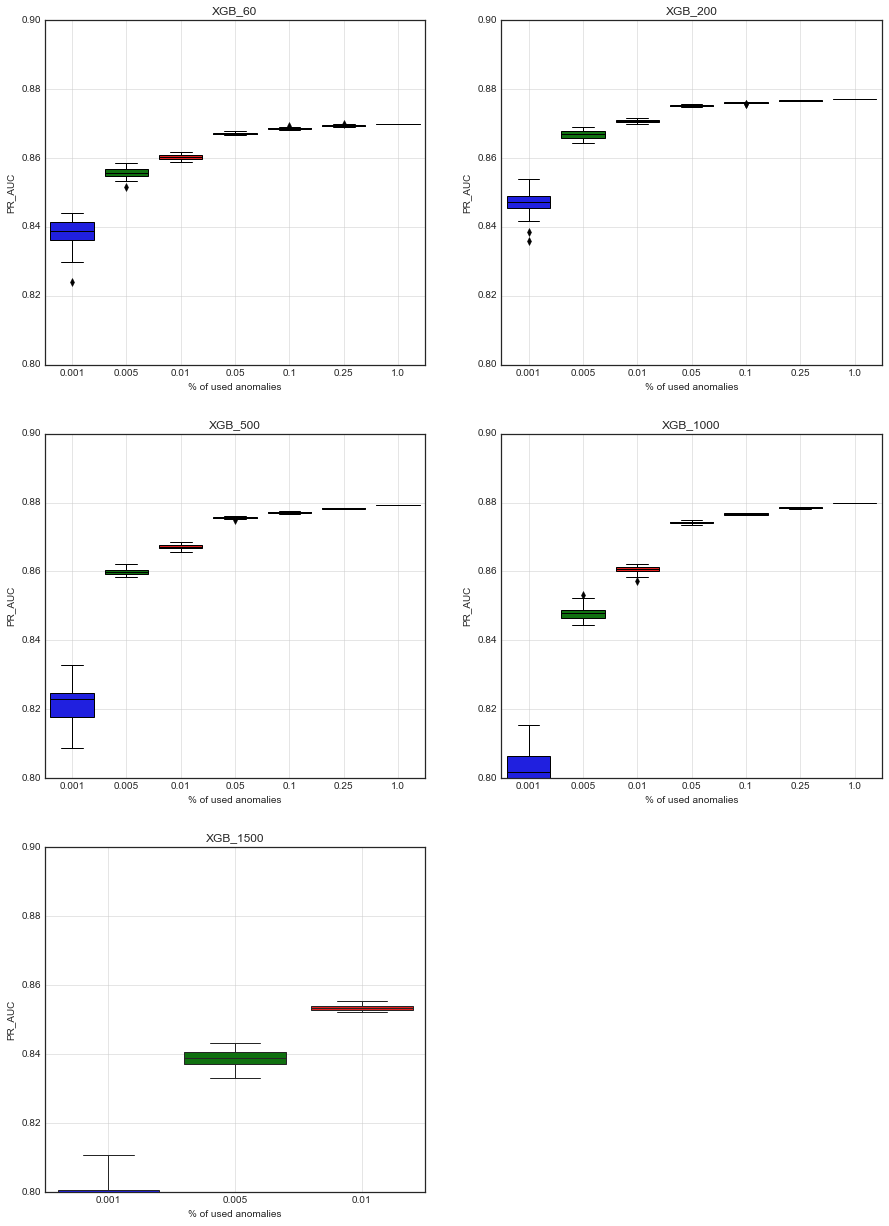

In [299]:
metric_boxplot(supervised_pr_aucs, ylabel='PR_AUC', ylim=(0.8, 0.9))

ROC AUC для XGBoostClassifier при n_estimators = [60, 200, 500, 1000, 1500]

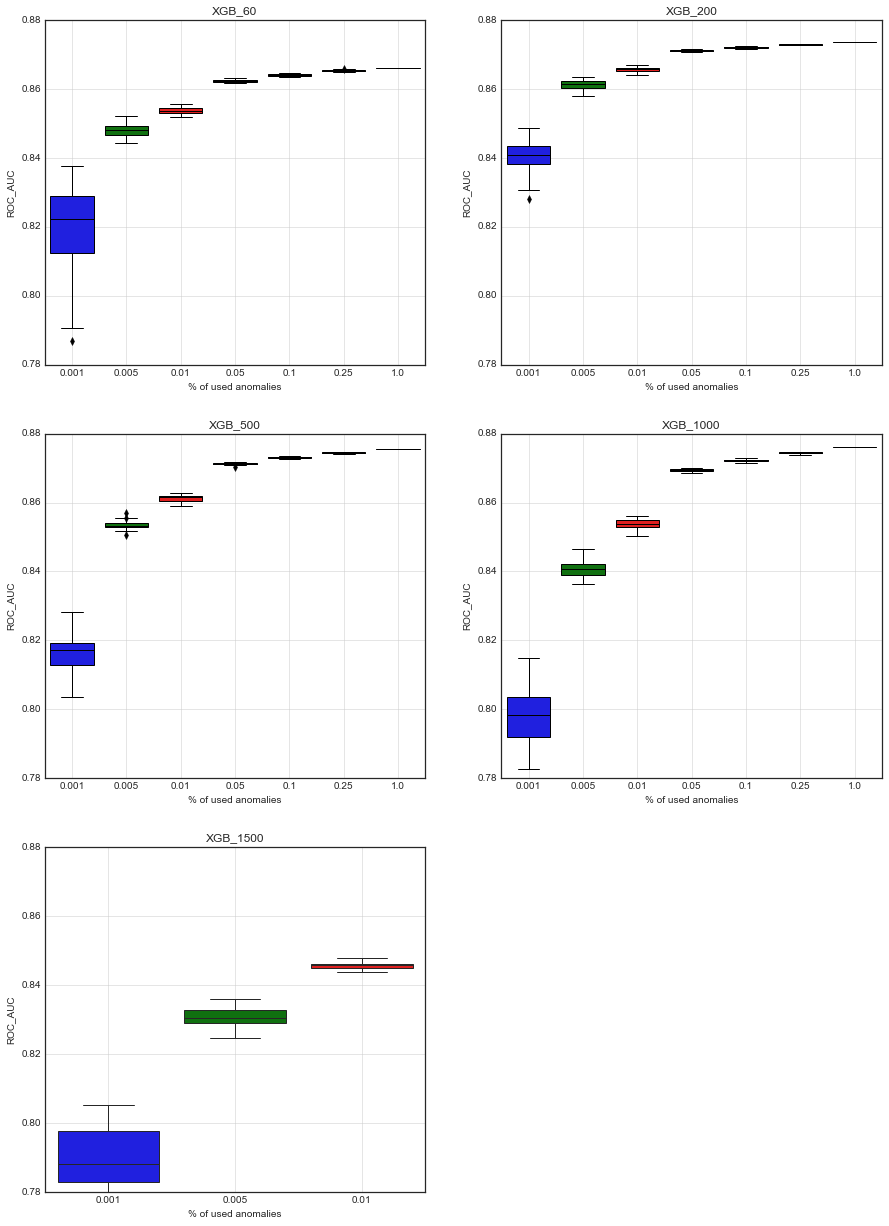

In [300]:
metric_boxplot(supervised_roc_aucs, ylabel='ROC_AUC', ylim=(0.78, 0.88))

P@10 для XGBoostClassifier при n_estimators = [60, 200, 500, 1000, 1500]

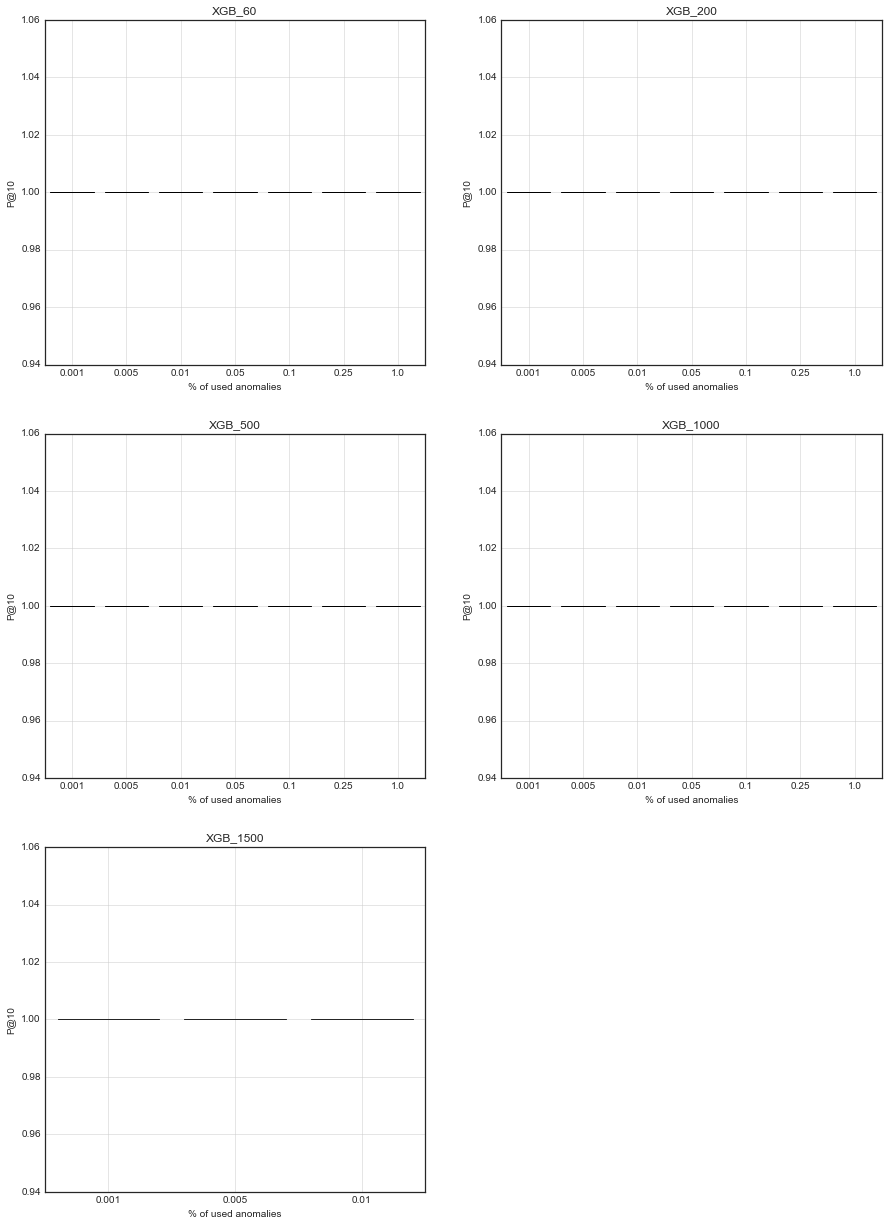

In [301]:
metric_boxplot(supervised_p_at_10, ylabel='P@10')

P@R:[0.8, 0.9, 0.95, 0.99] для XGBoostClassifier при n_estimators = [60, 200, 500, 1000, 1500]

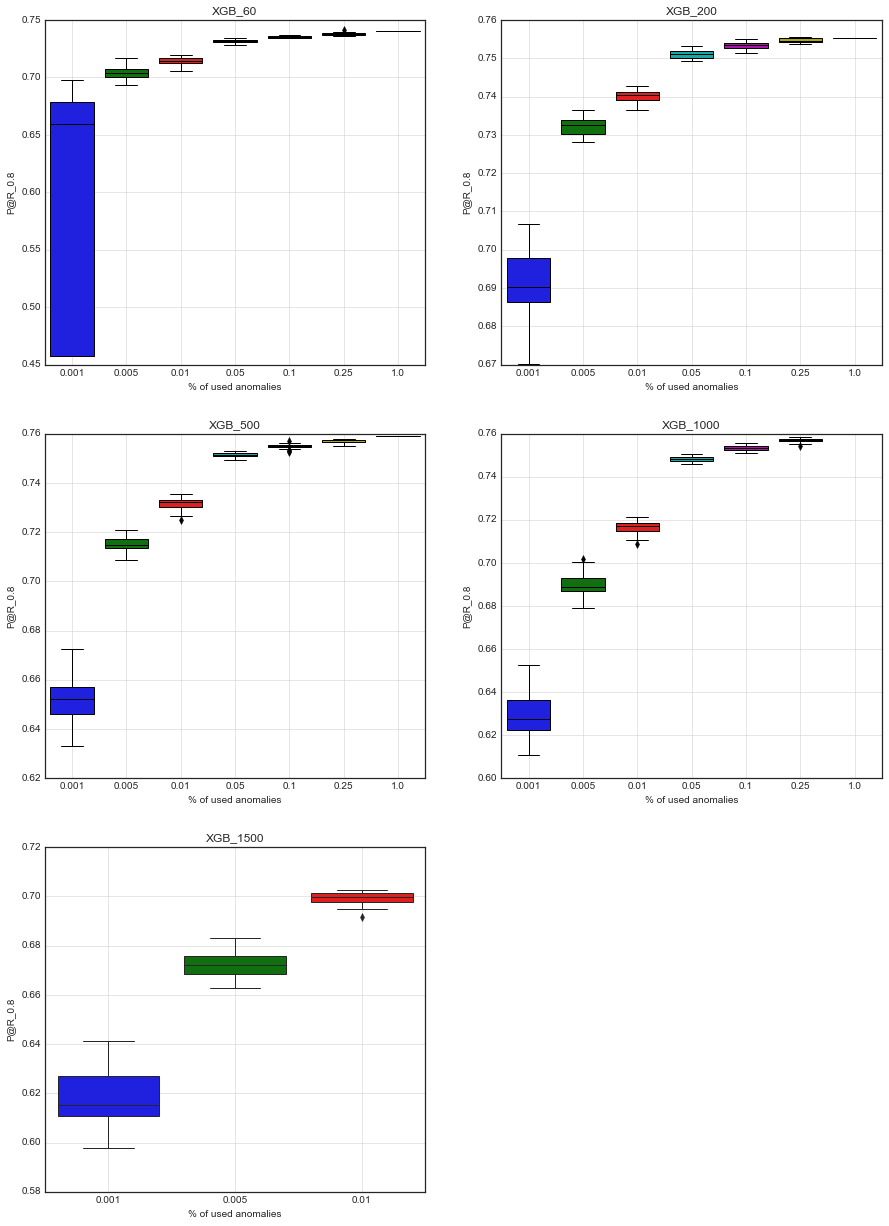

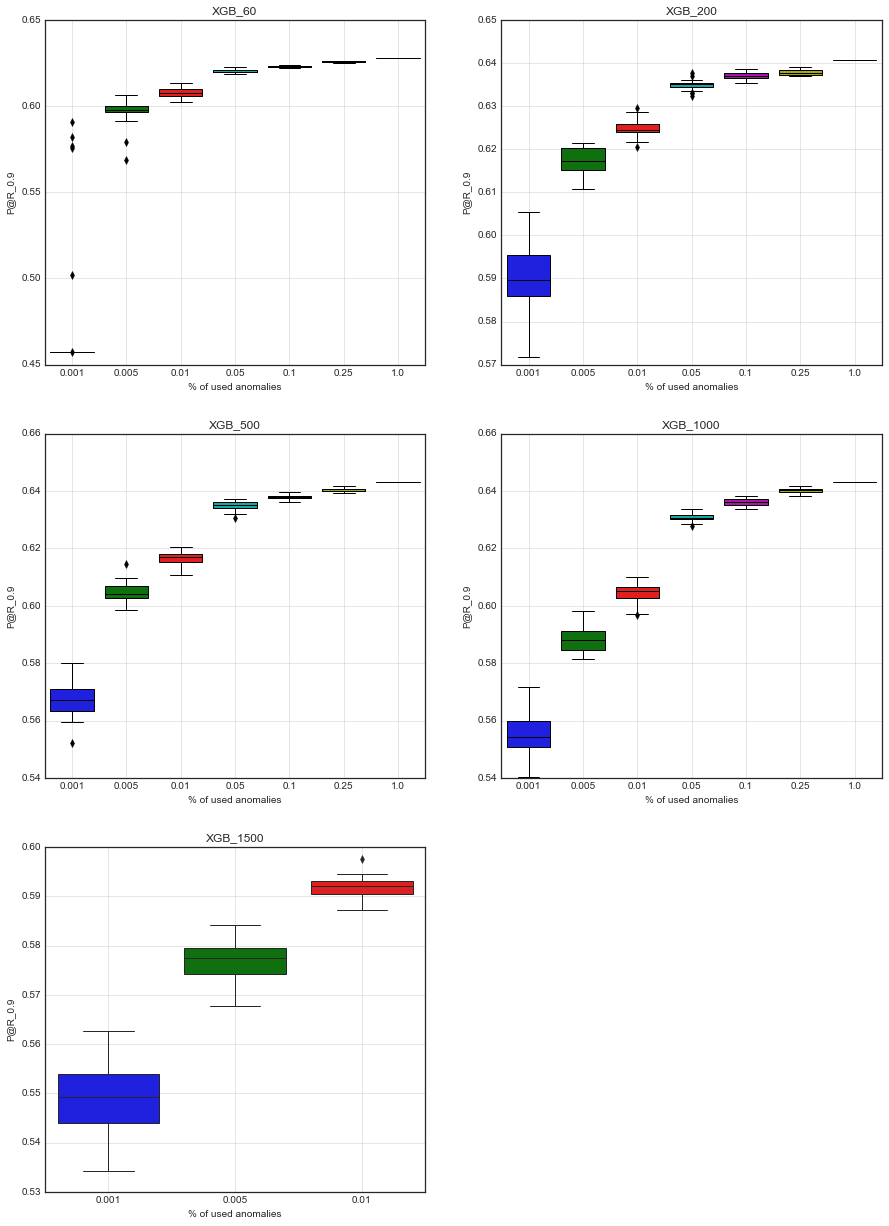

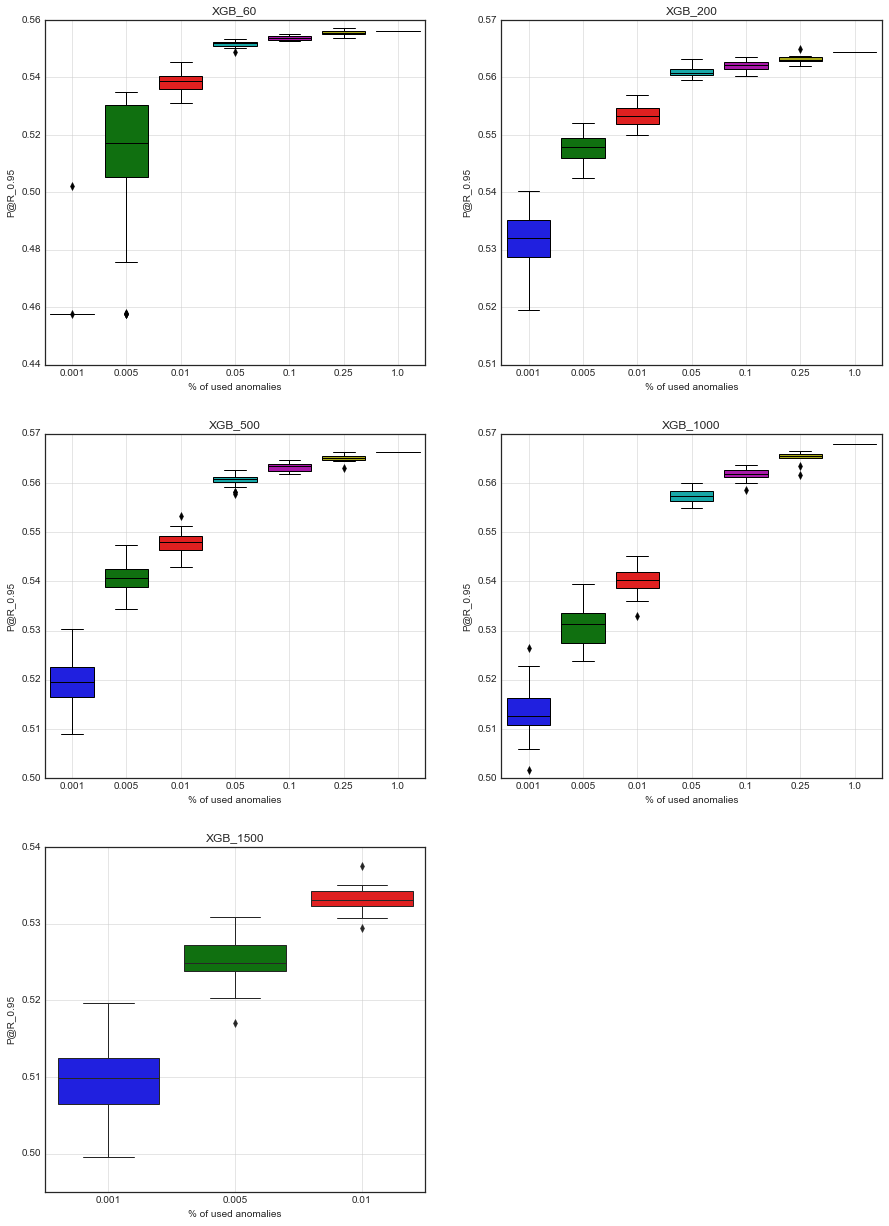

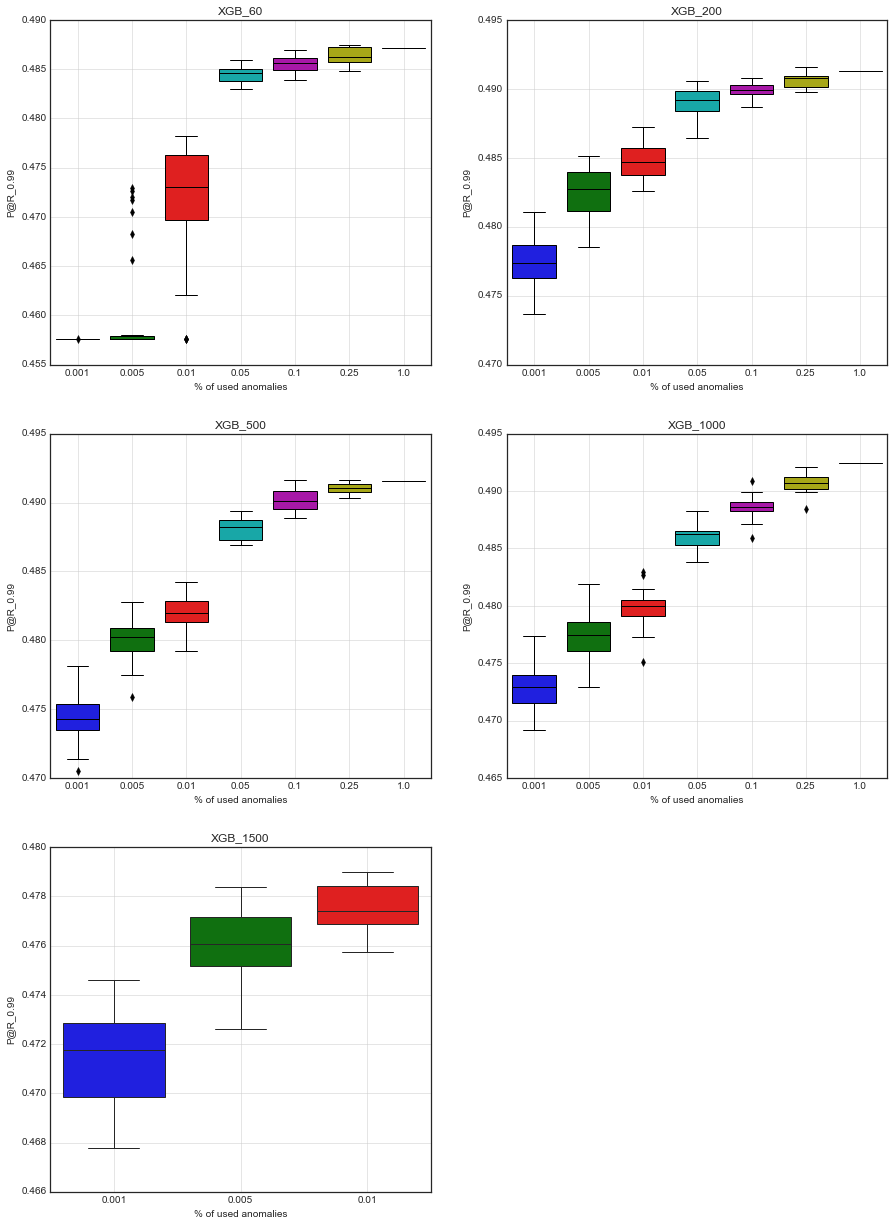

In [302]:
for k in supervised_p_at_r.keys():
    metric_boxplot(supervised_p_at_r[k], ylabel='P@R_' + str(k))
    plt.show()

# <font color="red">!!!Ахтунг!!!</font>

Полагаю, что я не прав раз так сделал, но я не понял как правильно и об этом надо сказать.

- XGB прогонялся на 10% от SUSY(разбил, используя stratify). Т.е. в train 216974 экземпляров класса 1 из 400к данных в train. Короче классы немного, но не сбалансированы.
- (1+e) и unsupervised прогонялись на том же количестве данных, но после переписки в чате про нескалируемость метрик, я подумал, что надо бы сбалансировать классы, чтобы "% используемых аномалий" был более интерпретируем. Т.е. в train 200к экземпляров класса 1 и 200к класса 0.

Как правильно?

# !!!Ахтунг!!!

## Unsupervised

Костыльная загрузка метрик для unsupervised алгоритмов

In [303]:
def init_unsupervised(metrics_path):
    metrics = load_metrics(metrics_path)
    unsupervised_pr_aucs = metrics['unsupervised_pr_aucs']
    unsupervised_roc_aucs = metrics['unsupervised_roc_aucs']
    unsupervised_p_at_n = metrics['unsupervised_p_at_n']
    unsupervised_p_at_r = metrics['unsupervised_p_at_r']
    return unsupervised_pr_aucs, unsupervised_roc_aucs, unsupervised_p_at_n, unsupervised_p_at_r

In [304]:
metrics_path = './metrics/unsupervised/'
unsupervised_pr_aucs, unsupervised_roc_aucs, unsupervised_p_at_n, unsupervised_p_at_r = init_unsupervised(metrics_path)

#### Построим графики

PR AUC для One-Class SVM и Isolation Forest

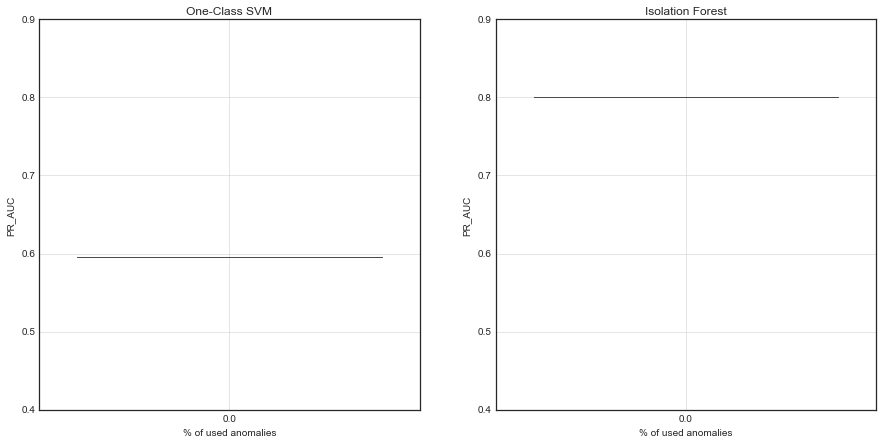

In [305]:
metric_boxplot(unsupervised_pr_aucs, ylabel='PR_AUC', ylim=(0.4, 0.9))

ROC AUC для One-Class SVM и Isolation Forest

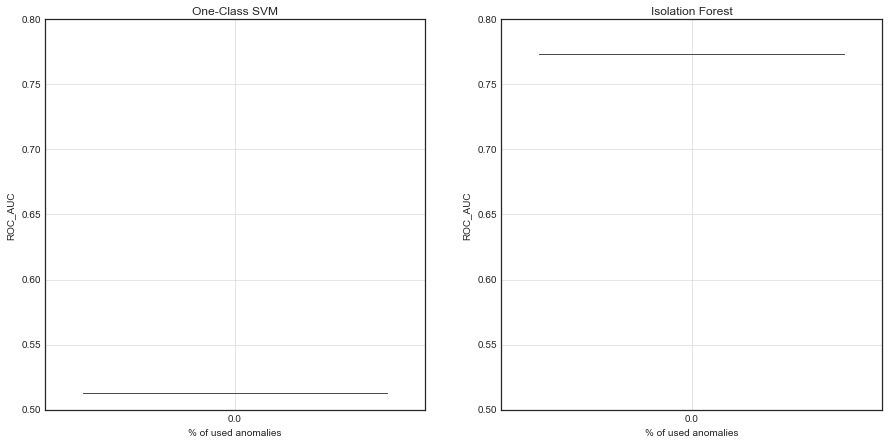

In [306]:
metric_boxplot(unsupervised_roc_aucs, ylabel='ROC_AUC', ylim=(0.5, 0.8))

P@n тоже самое что и Precision at 10 только вместо 10 разные n

P@n:[10, 100, 200, 500, 1000, 2000, 5000] для One-Class SVM и Isolation Forest

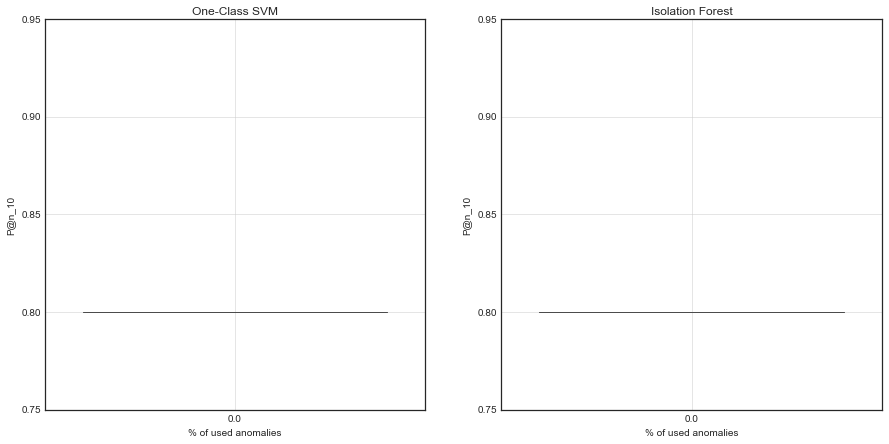

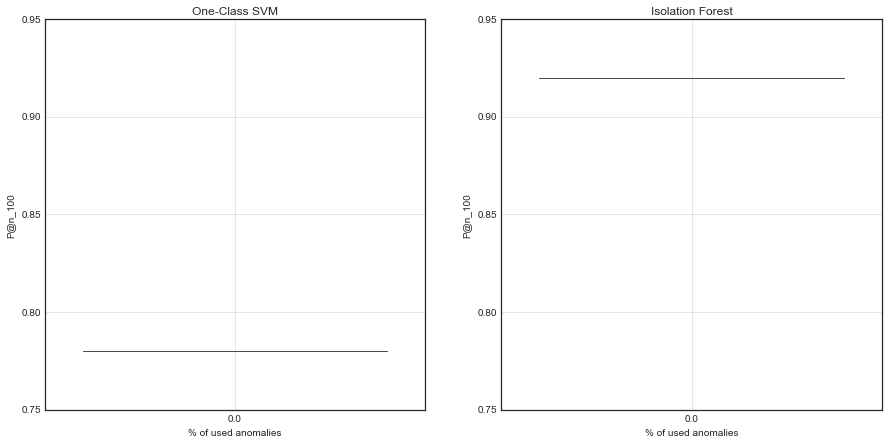

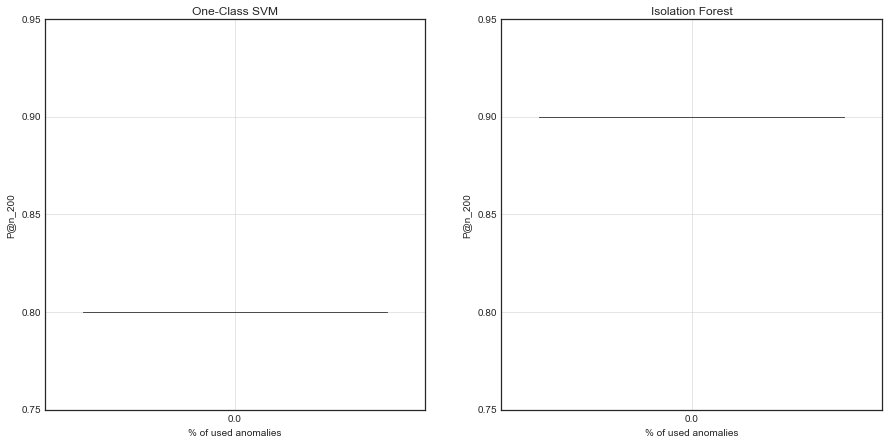

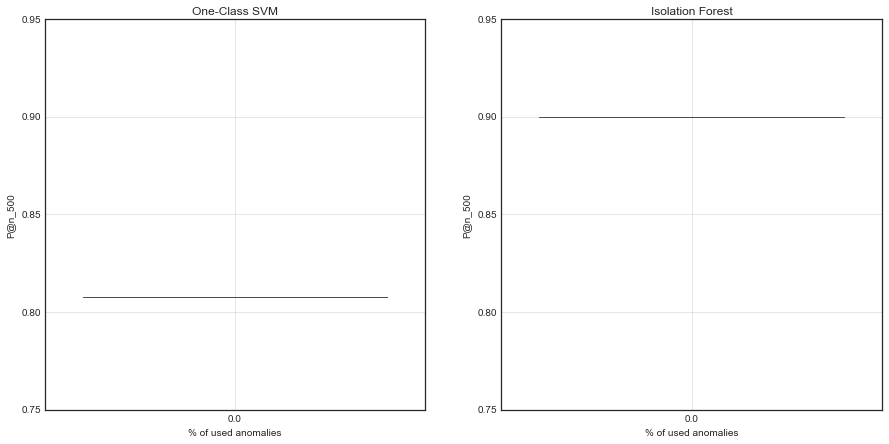

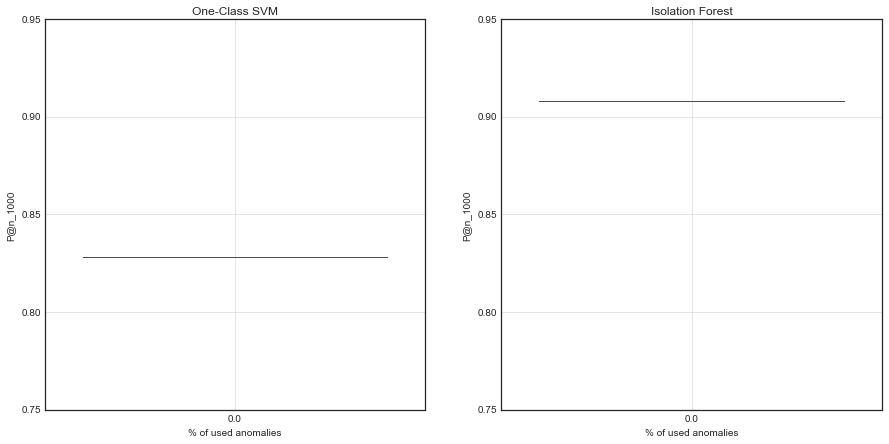

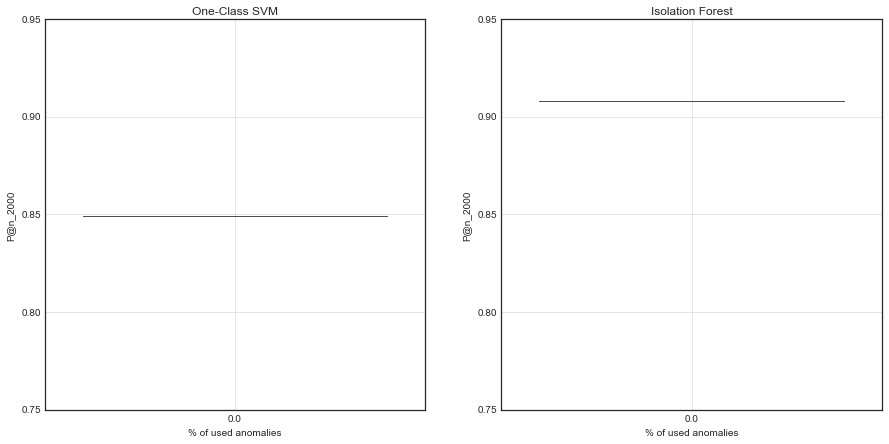

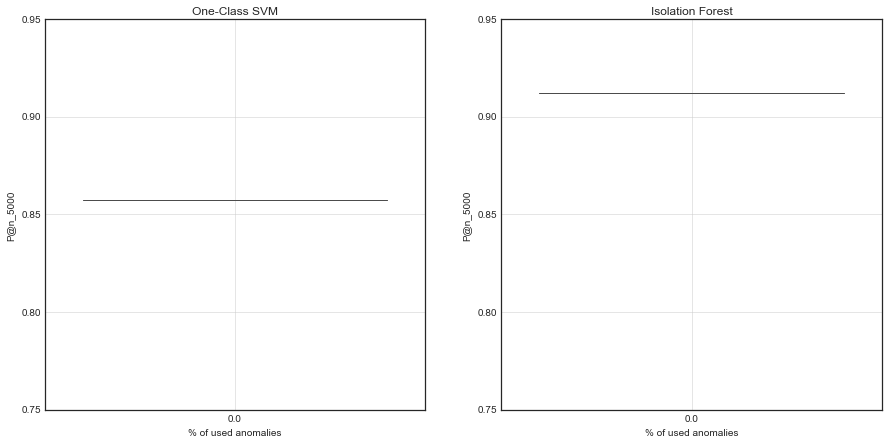

In [307]:
for k in unsupervised_p_at_n.keys():
    metric_boxplot(unsupervised_p_at_n[k], ylabel='P@n_' + str(k), ylim=(0.75, 0.95))
    plt.show()

P@R:[0.8, 0.9, 0.95, 0.99] для One-Class SVM и Isolation Forest

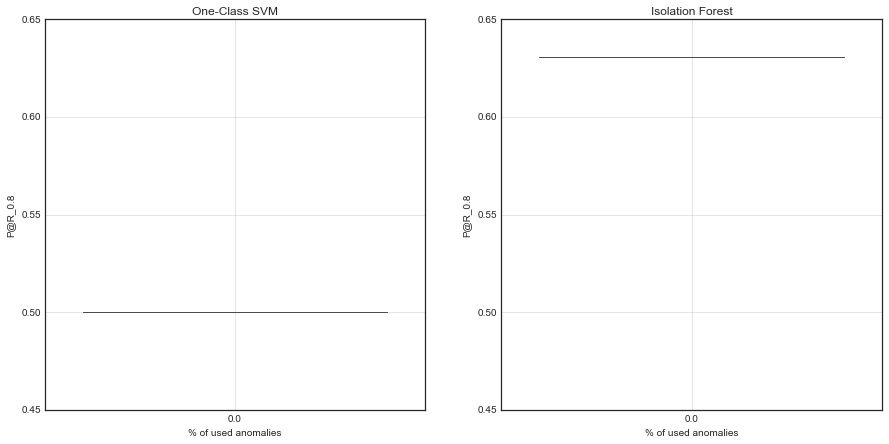

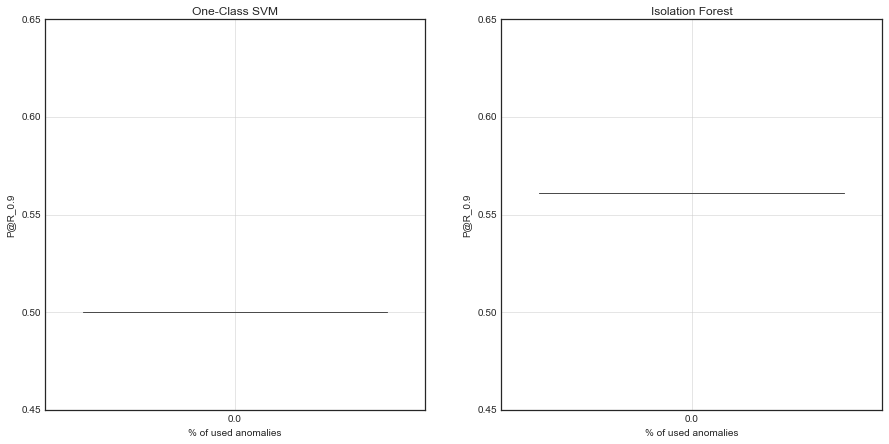

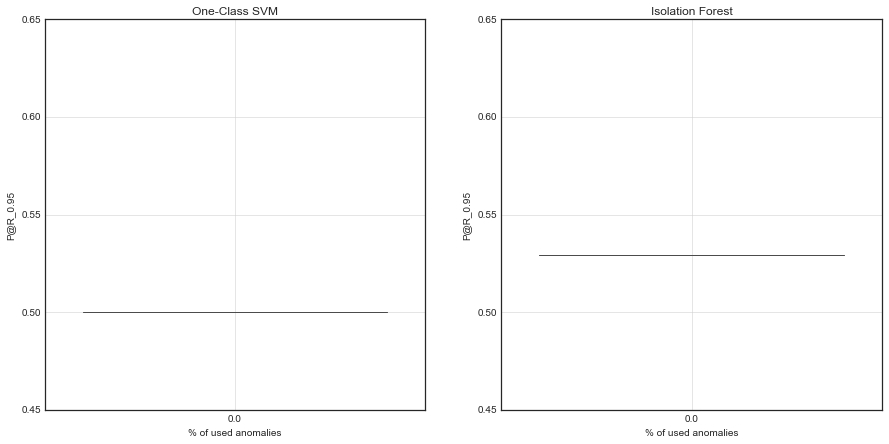

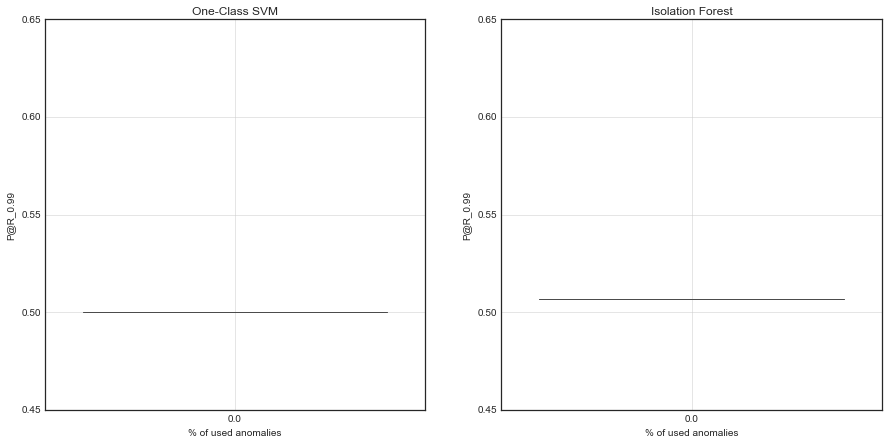

In [308]:
for k in unsupervised_p_at_r.keys():
    metric_boxplot(unsupervised_p_at_r[k], ylabel='P@R_' + str(k), ylim=(0.45, 0.65))
    plt.show()

# (1 + e) алгоритм

Костыльная загрузка метрик для (1 + e) алгоритмов(разные alpha, разные алгоритмы)

<a href="https://3.basecamp.com/3895643/buckets/5714528/messages/993962676">Про разные alpha</a>

In [309]:
def init_ours(metrics_path):
    metrics = load_metrics(metrics_path)
    ours_pr_aucs = metrics['ours_pr_aucs']
    ours_roc_aucs = metrics['ours_roc_aucs']
    ours_p_at_n = metrics['ours_p_at_n']
    ours_p_at_r = metrics['ours_p_at_r']
    return ours_pr_aucs, ours_roc_aucs, ours_p_at_n, ours_p_at_r

Склеим разные alpha

In [310]:
alphas = list(map(str, [0, 0.1, 0.25, 0.5 ,1]))

In [311]:
metrics_path = './metrics/our/alpha_'
ours_pr_aucs, ours_roc_aucs, ours_p_at_n, ours_p_at_r = {}, {}, defaultdict(dict), defaultdict(dict)
for alpha in alphas:
    cur_ours_pr_aucs, cur_ours_roc_aucs, cur_ours_p_at_n, cur_ours_p_at_r = init_ours(metrics_path + alpha)
    ours_pr_aucs[alpha] = cur_ours_pr_aucs[alpha]
    ours_roc_aucs[alpha] = cur_ours_roc_aucs[alpha]
    for k in cur_ours_p_at_n.keys():
        ours_p_at_n[k][alpha] = cur_ours_p_at_n[k][alpha]
    for k in cur_ours_p_at_r.keys():
        ours_p_at_r[k][alpha] = cur_ours_p_at_r[k][alpha]

In [312]:
ours_pr_aucs.keys()

dict_keys(['0', '0.1', '0.25', '0.5', '1'])

In [313]:
ours_pr_aucs

{'0': [[0, 0.70166942285522]],
 '0.1': [[0.0, 0.40478186055513277],
  [0.001, 0.7899825187822869],
  [0.005, 0.8644412987343152],
  [0.01, 0.8770246683076308],
  [0.05, 0.8907582660755066],
  [0.1, 0.8929863611599652],
  [0.25, 0.8938005251162531],
  [1.0, 0.8949152611276135],
  [0.0, 0.434761257497388],
  [0.001, 0.797836769183142],
  [0.005, 0.863928192036351],
  [0.01, 0.8813849339743524],
  [0.05, 0.8905231823816318],
  [0.1, 0.8932788648358791],
  [0.25, 0.894040737667608],
  [1.0, 0.8949805153455763],
  [0.0, 0.4042229894197035],
  [0.001, 0.7637502354955485],
  [0.005, 0.8639916467609476],
  [0.01, 0.8769822957360609],
  [0.05, 0.890988565215694],
  [0.1, 0.8929771946076597],
  [0.25, 0.8940492326293606],
  [1.0, 0.8949067250196718],
  [0.0, 0.40051024034634464],
  [0.001, 0.7867297700659557],
  [0.005, 0.8607840915662767],
  [0.01, 0.877000570679414],
  [0.05, 0.8900745005160098],
  [0.1, 0.8928161437733215],
  [0.25, 0.8942400465288771],
  [1.0, 0.8947881687337471],
  [0.0, 0.

#### Построим графики

Делал несколько перезапусков обучения, изменяя используемые негативные примеры

In [314]:
fraction_of_negative_used = np.array([0, 0.1, 0.5, 1, 5, 10, 25, 100]) / 100.
n_resplits = np.ones_like(fraction_of_negative_used, dtype=np.int) * 10
print(*map(lambda pair: "{} раз перезапускал обучение при доли негативного класса: {}".format(*pair), 
          zip(n_resplits, fraction_of_negative_used)), sep='\n')

10 раз перезапускал обучение при доли негативного класса: 0.0
10 раз перезапускал обучение при доли негативного класса: 0.001
10 раз перезапускал обучение при доли негативного класса: 0.005
10 раз перезапускал обучение при доли негативного класса: 0.01
10 раз перезапускал обучение при доли негативного класса: 0.05
10 раз перезапускал обучение при доли негативного класса: 0.1
10 раз перезапускал обучение при доли негативного класса: 0.25
10 раз перезапускал обучение при доли негативного класса: 1.0


#### title == alpha value

PR AUC для (1 + e)

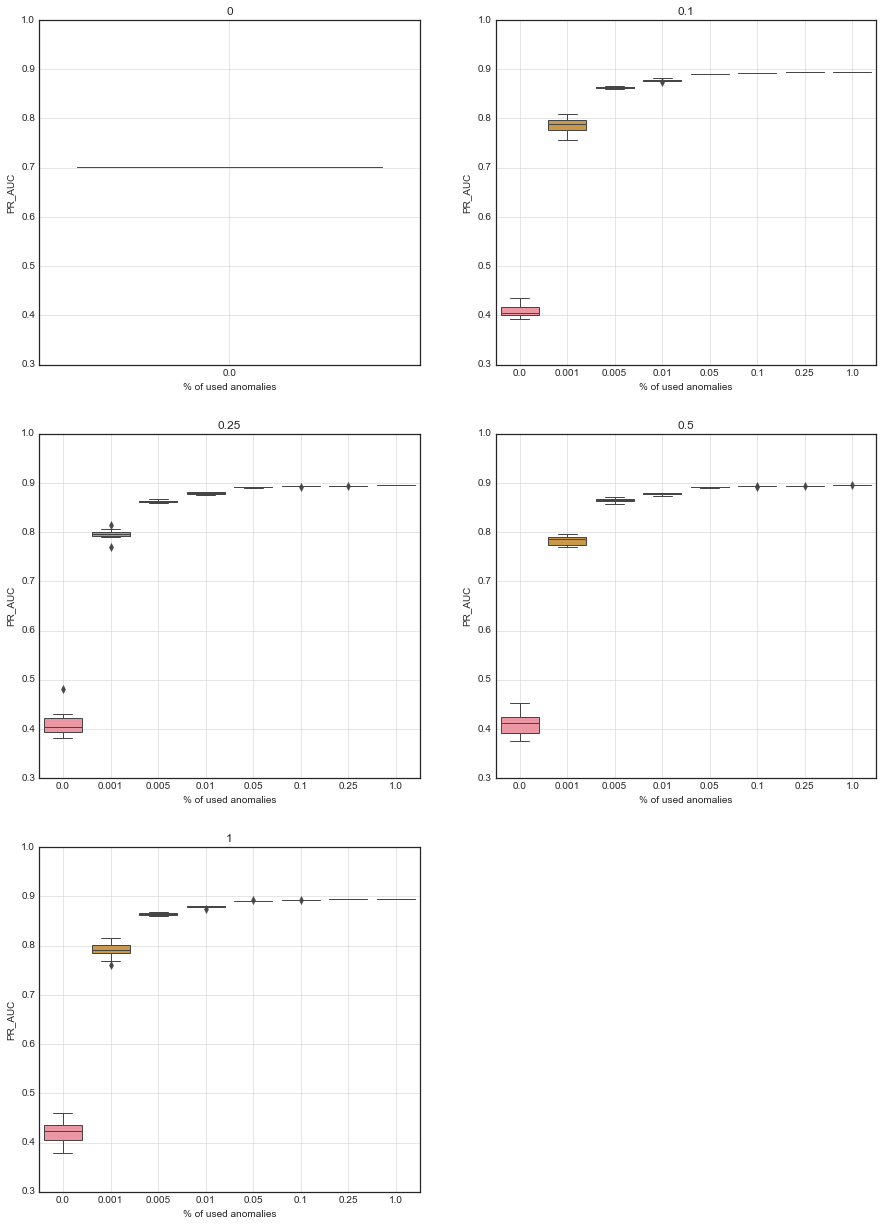

In [315]:
metric_boxplot(ours_pr_aucs, ylabel='PR_AUC', ylim=(0.3, 1))

ROC AUC для (1 + e)

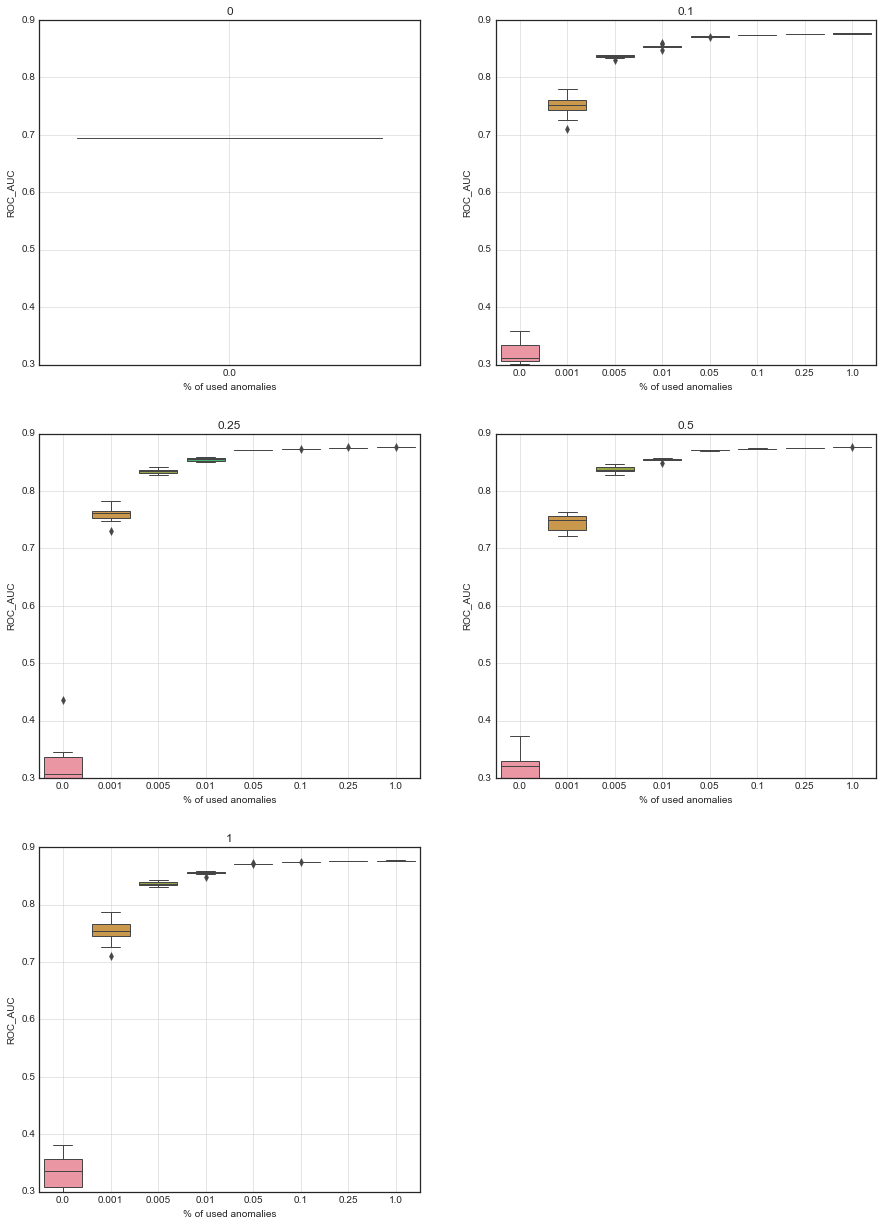

In [316]:
metric_boxplot(ours_roc_aucs, ylabel='ROC_AUC', ylim=(0.3, 0.9))

P@n тоже самое что и Precision at 10 только вместо 10 разные n

P@n:[10, 100, 200, 500, 1000, 2000, 5000] для (1 + e)

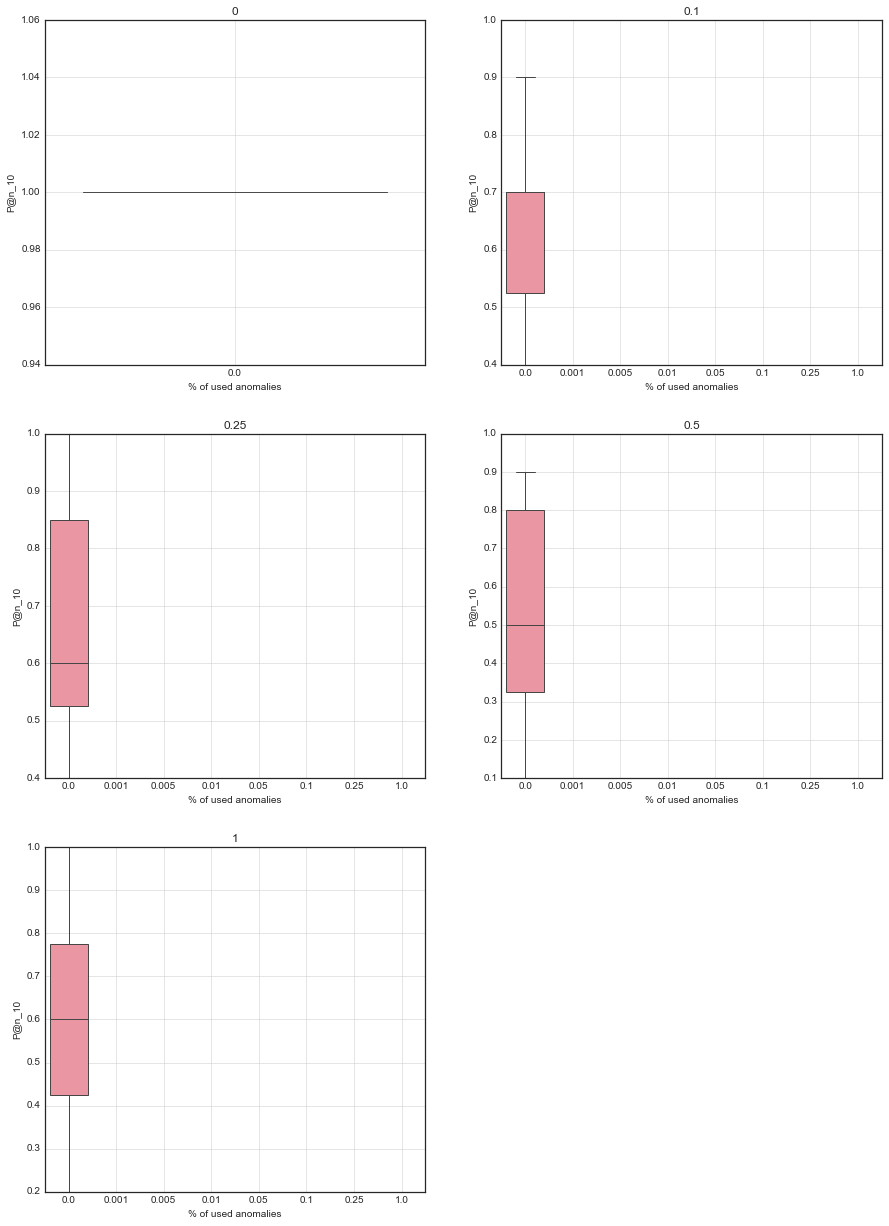

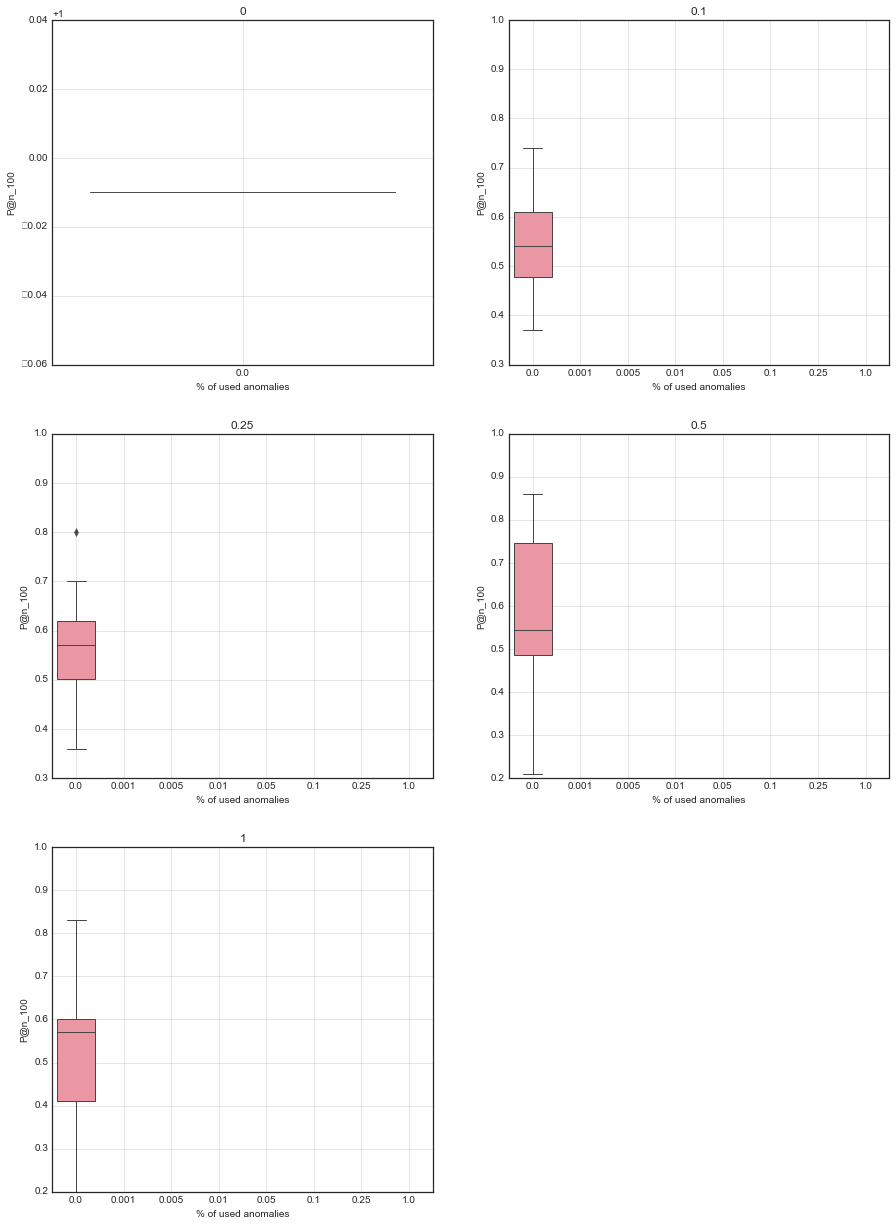

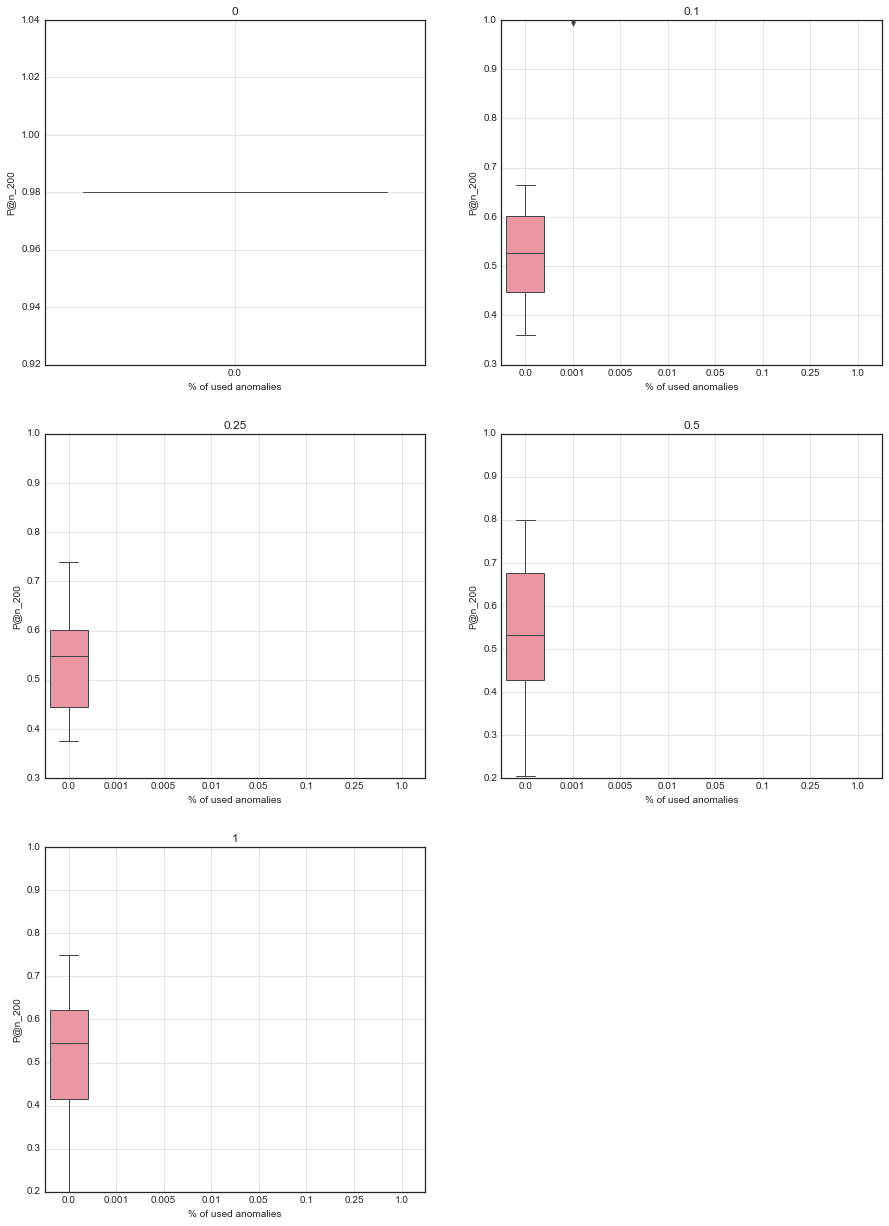

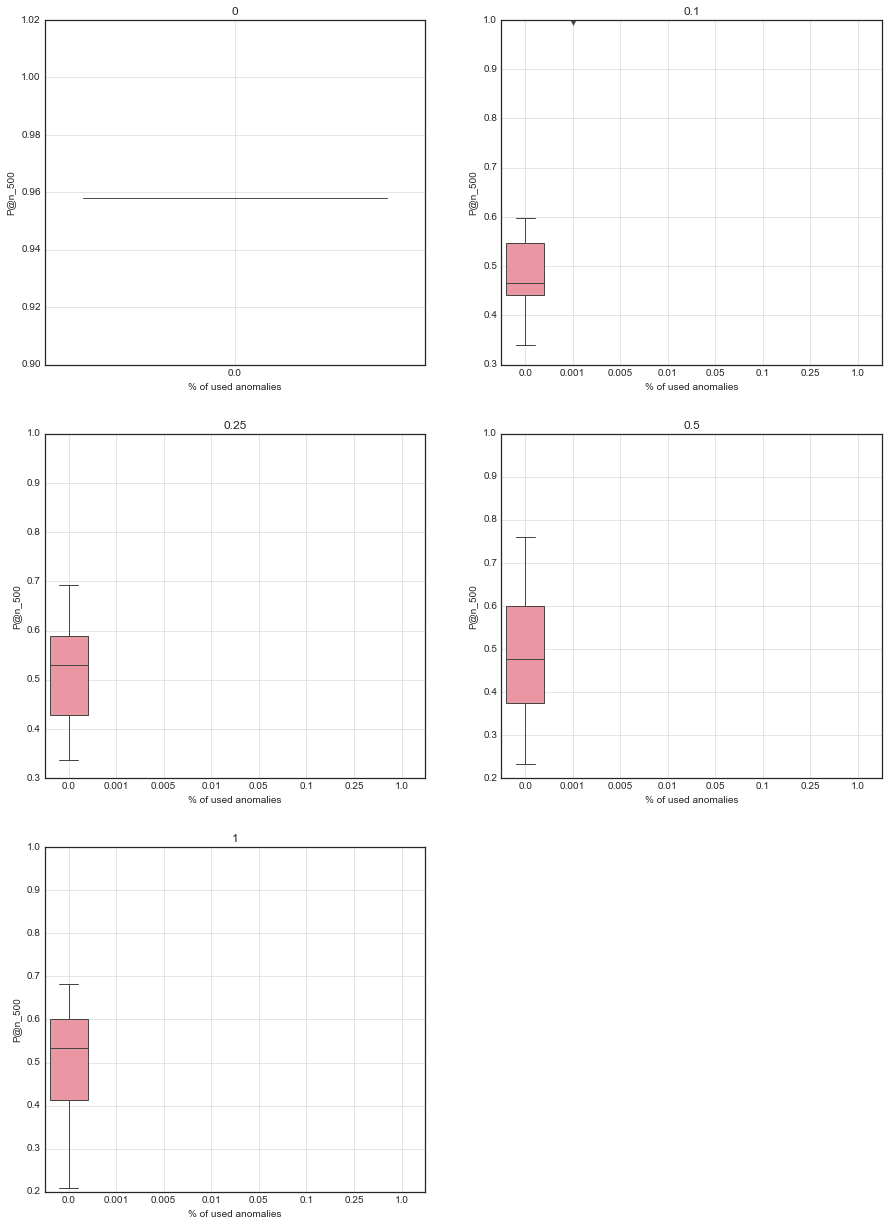

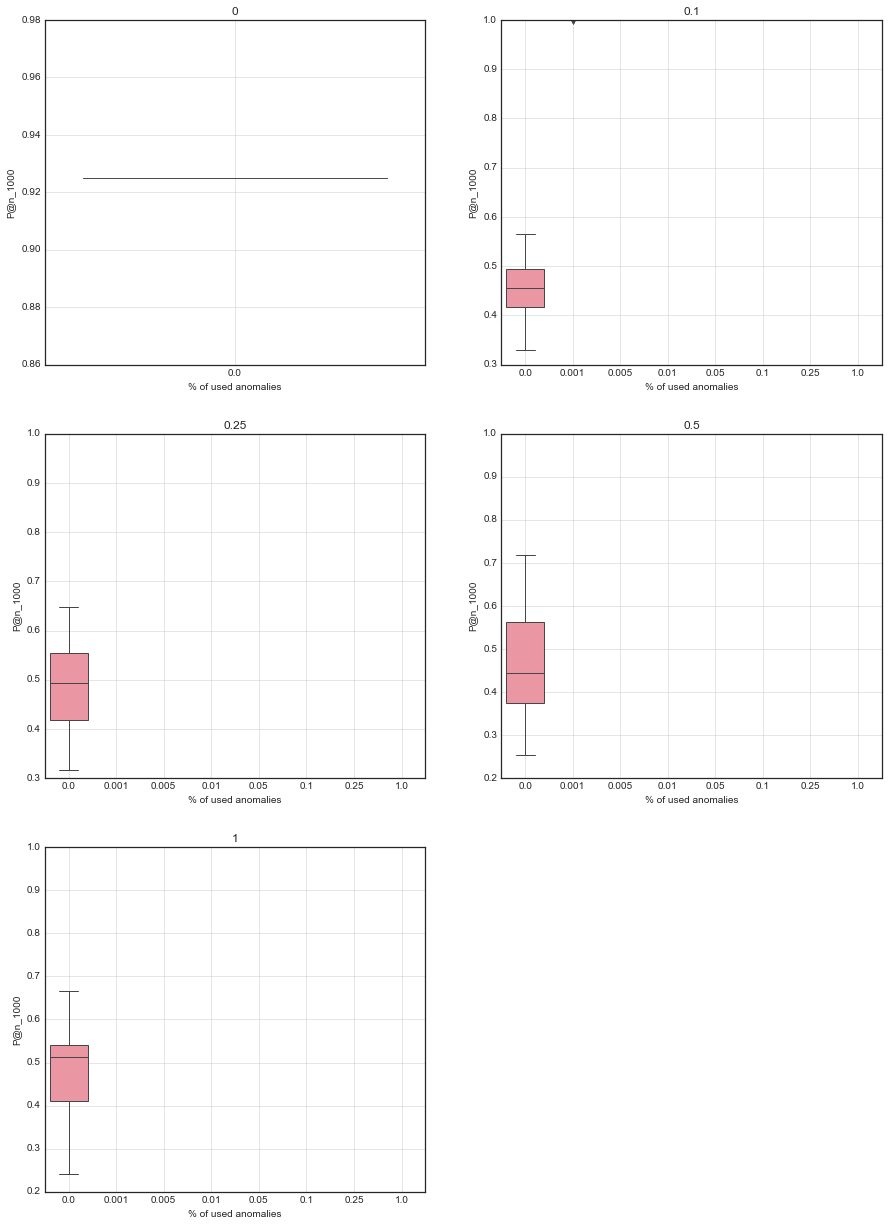

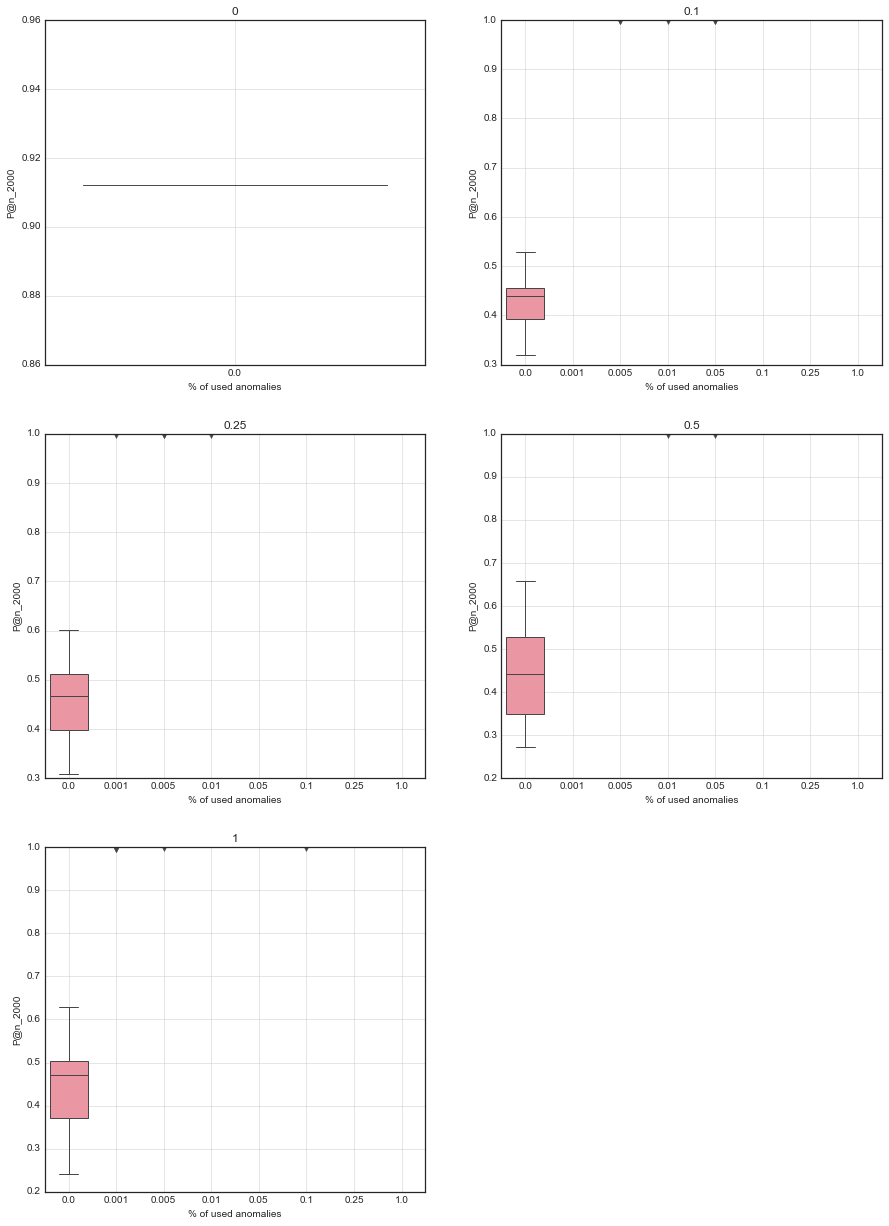

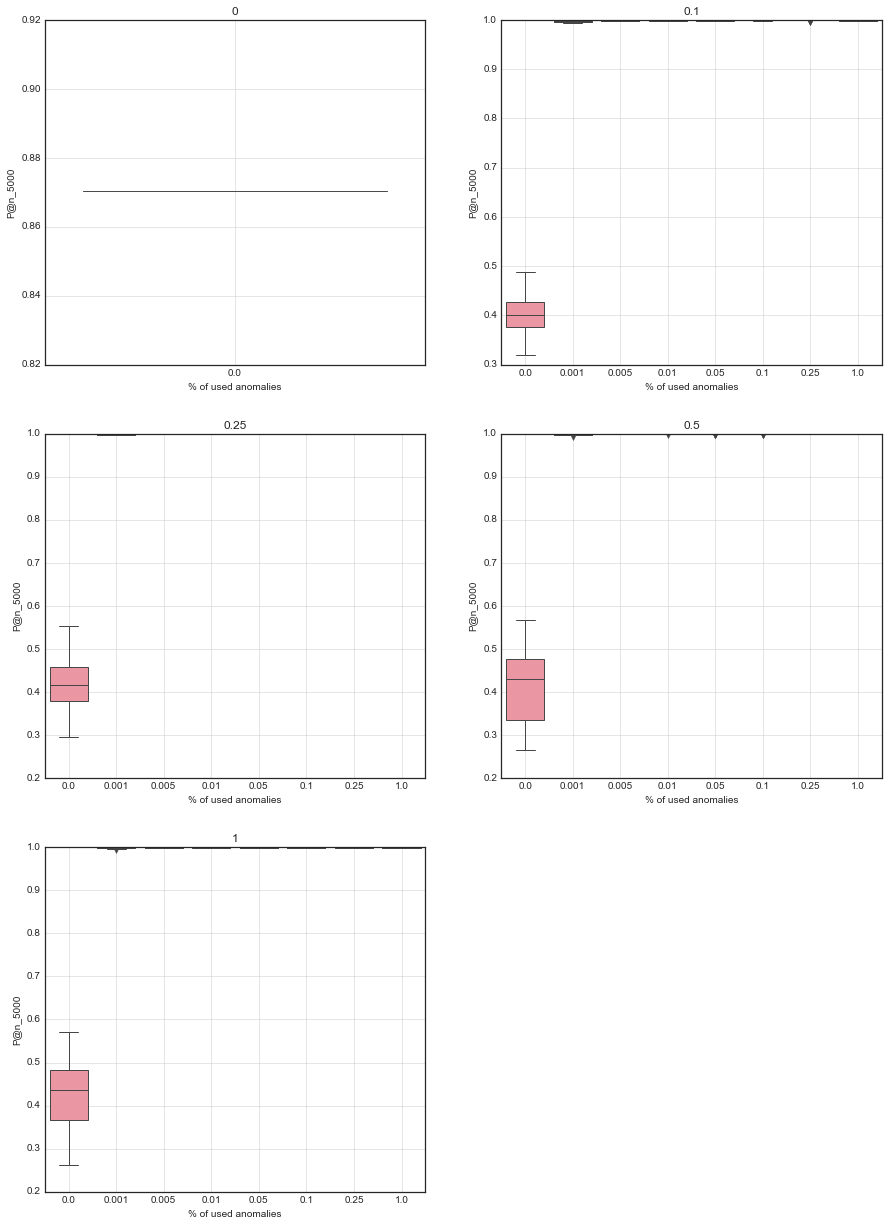

In [317]:
for k in ours_p_at_n.keys():
    metric_boxplot(ours_p_at_n[k], ylabel='P@n_' + str(k))
    plt.show()

P@R:[0.8, 0.9, 0.95, 0.99] для (1 + e)

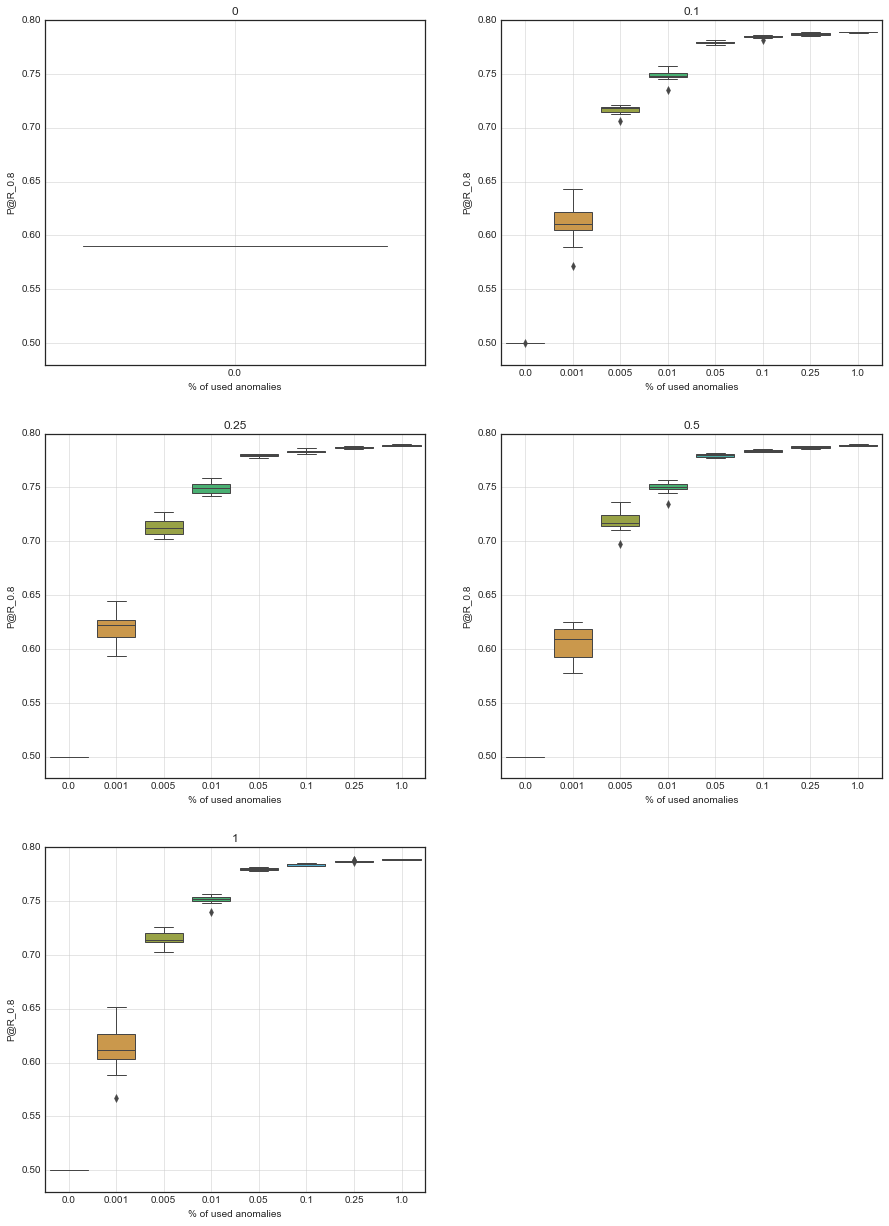

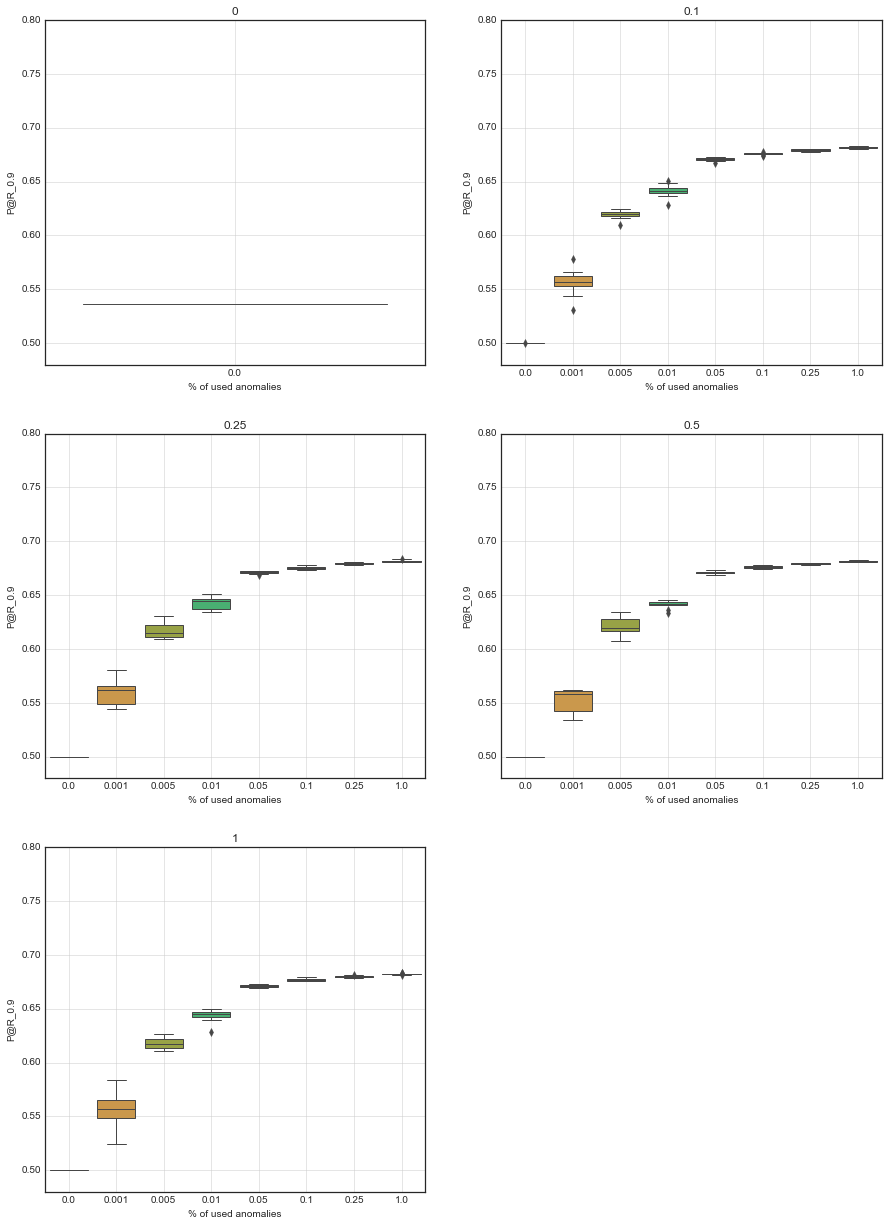

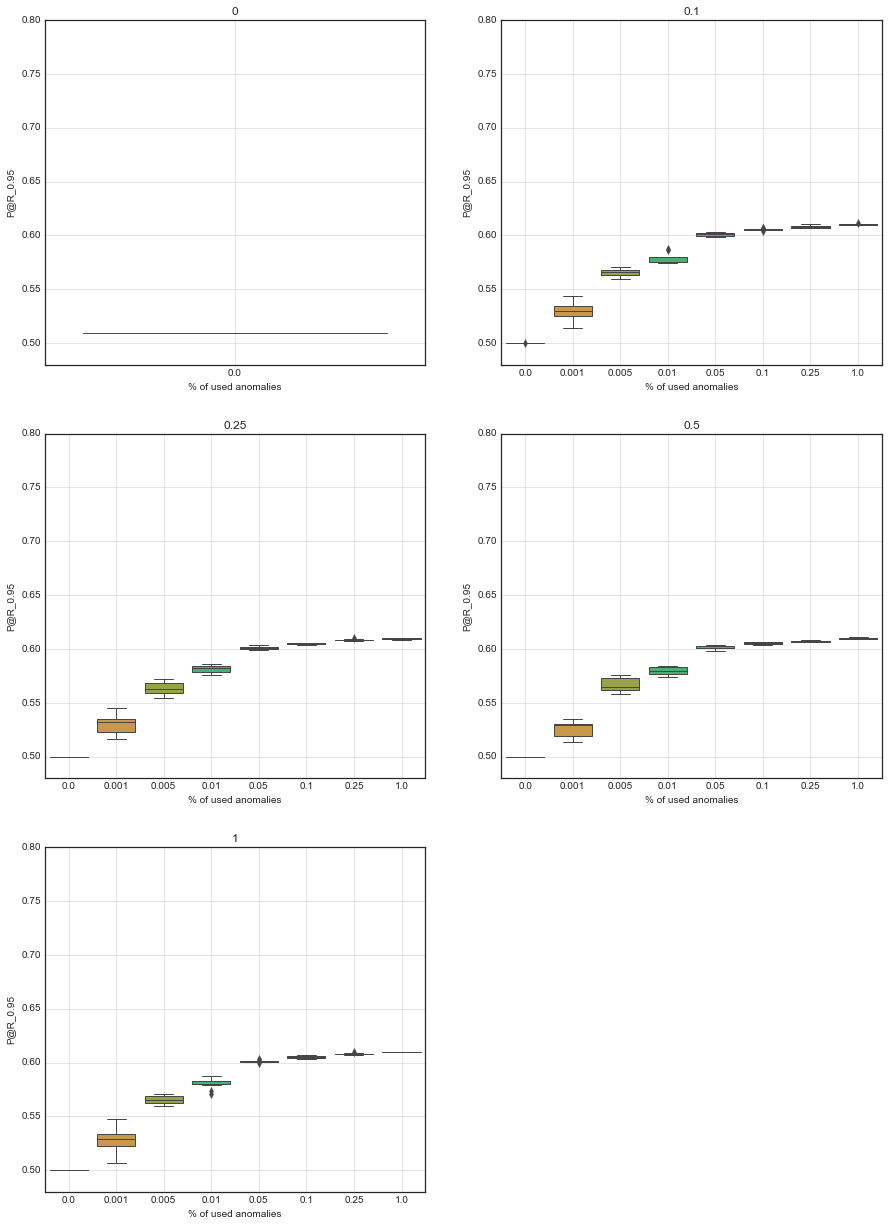

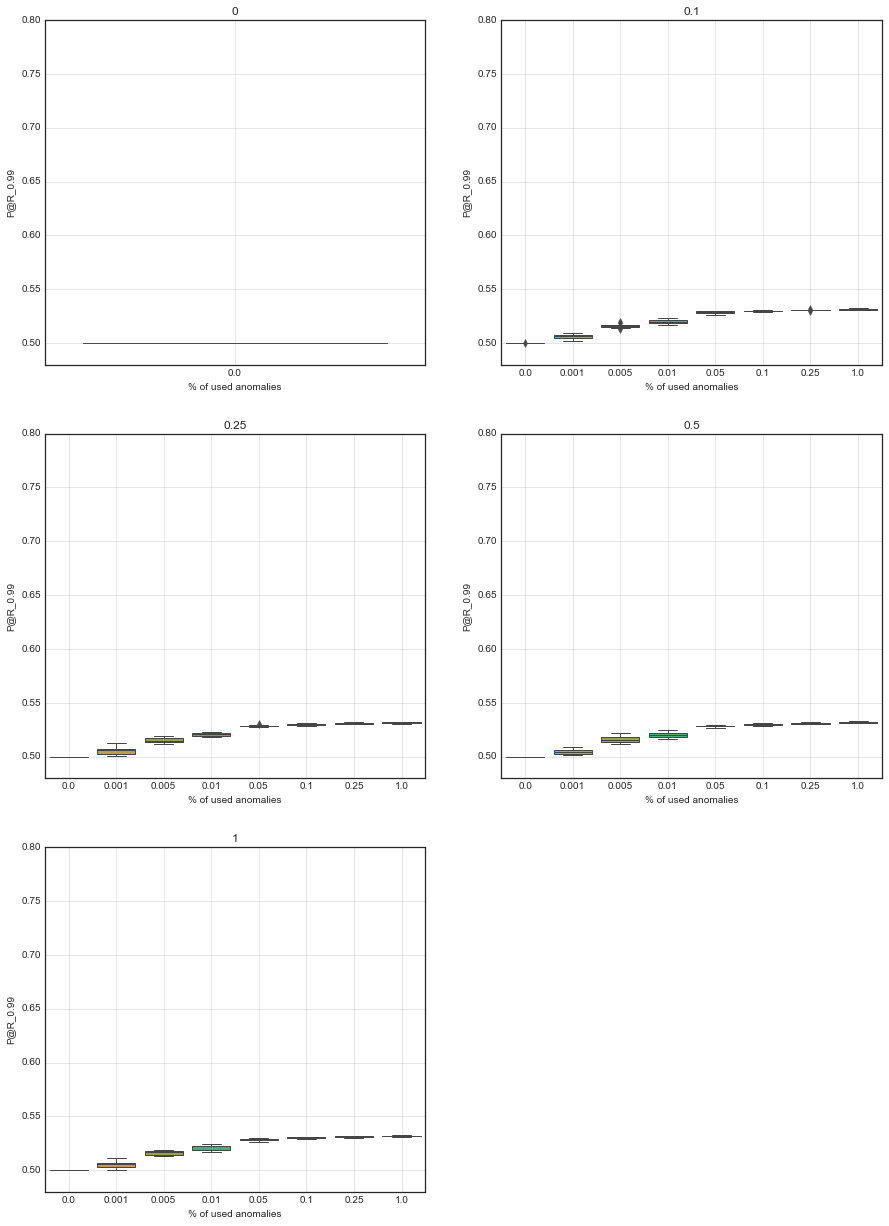

In [318]:
for k in ours_p_at_r.keys():
    metric_boxplot(ours_p_at_r[k], ylabel='P@R_' + str(k), ylim=(0.48, 0.8))
    plt.show()

## Построим все алгоритмы на одном графике

Усреднение значений метрики по долям используемых аномалий(нужно для supervised и ours, кроме alpha=0)

In [319]:
def mean_metric(metric_arr):
    """
    Params
    ------
    metric_arr: list, shape=(n_metric_values, 2)
        format=[[frac, metric_value], ...]
        frac == fraction of negative data used
        
    Return
    ------
    metric_reduce: list, shape=(n_fractions, 2)
    """
    metric_map = defaultdict(list)
    for x, y in metric_arr:
        metric_map[x].append(y)
    metric_reduce = [[k, np.mean(v)] for k, v in metric_map.items()]
    metric_reduce.sort()
    return metric_reduce

In [320]:
mean_metric(supervised_pr_aucs['XGB_200'])

[[0.001, 0.8470996576039838],
 [0.005, 0.8668208546212564],
 [0.01, 0.870641907138626],
 [0.05, 0.8751494638326142],
 [0.1, 0.876048274391336],
 [0.25, 0.8766662105099599],
 [1.0, 0.8770793071443757]]

Дублируем значения метрик на все доли используемых аномалий(нужно для unsupervised и ours при alpha=0)

In [321]:
def dublicate_metric(metric_arr, fraction_of_negative_used):
    """
    Params
    ------
    metric_arr: list, shape=(1, 2)
        format=[[frac, metric_value]]
        frac == fraction of negative data used
    """
    return [[frac, metric_arr[0][1]] for frac in fraction_of_negative_used]

In [322]:
fraction_of_negative_used = np.array([0, 0.1, 0.5, 1, 5, 10, 25, 100]) / 100.

In [323]:
unsupervised_pr_aucs['Isolation Forest']

[[0, 0.7999563725773787]]

In [324]:
dublicate_metric(unsupervised_pr_aucs['Isolation Forest'], fraction_of_negative_used)

[[0.0, 0.7999563725773787],
 [0.001, 0.7999563725773787],
 [0.005, 0.7999563725773787],
 [0.01, 0.7999563725773787],
 [0.05, 0.7999563725773787],
 [0.1, 0.7999563725773787],
 [0.25, 0.7999563725773787],
 [1.0, 0.7999563725773787]]

Добавим недостающие измерения для долей. Присвоим значение 0.5(нужно для supervised)

In [325]:
def expand_metric(metric_arr, fraction_of_negative_used):
    """
    Params
    ------
    metric_arr: list, shape=(n_metric_values, 2)
        format=[[frac, metric_value]]
        frac == fraction of negative data used
    """
    frac2metric = {frac: metric for frac, metric in metric_arr}
    res_metrics = [[frac, frac2metric.get(frac, 0.5)] for frac in fraction_of_negative_used]
    res_metrics.sort()
    return res_metrics

In [326]:
mean_metric(supervised_pr_aucs['XGB_200'])

[[0.001, 0.8470996576039838],
 [0.005, 0.8668208546212564],
 [0.01, 0.870641907138626],
 [0.05, 0.8751494638326142],
 [0.1, 0.876048274391336],
 [0.25, 0.8766662105099599],
 [1.0, 0.8770793071443757]]

In [327]:
expand_metric(mean_metric(supervised_pr_aucs['XGB_200']), fraction_of_negative_used)

[[0.0, 0.5],
 [0.001, 0.8470996576039838],
 [0.005, 0.8668208546212564],
 [0.01, 0.870641907138626],
 [0.05, 0.8751494638326142],
 [0.1, 0.876048274391336],
 [0.25, 0.8766662105099599],
 [1.0, 0.8770793071443757]]

In [328]:
# не все посчитал для n_estimators=1500
expand_metric(mean_metric(supervised_pr_aucs['XGB_1500']), fraction_of_negative_used)

[[0.0, 0.5],
 [0.001, 0.7930134020739199],
 [0.005, 0.8388027164295419],
 [0.01, 0.8535240842185615],
 [0.05, 0.5],
 [0.1, 0.5],
 [0.25, 0.5],
 [1.0, 0.5]]

Теперь выравняем измерения для различных алгоритмов по значениям fraction_of_negative_used

In [329]:
all_methods = list(unsupervised_pr_aucs.keys()) + list(ours_pr_aucs.keys()) + list(supervised_roc_aucs.keys())

In [330]:
all_methods

['One-Class SVM',
 'Isolation Forest',
 '0',
 '0.1',
 '0.25',
 '0.5',
 '1',
 'XGB_60',
 'XGB_200',
 'XGB_500',
 'XGB_1000',
 'XGB_1500']

In [331]:
ours_pr_aucs.keys()

dict_keys(['0', '0.1', '0.25', '0.5', '1'])

Из словарей {классификатор: метрика} делает один для всех классификаторов с выровненными по размеру значениями

In [332]:
def create_metrics_dict_by_clf(unsupervised, supervised, ours, fraction_of_negative_used):
    """
    Params
    ------
    unsupervised: dict, {clf_name: [[frac, metric_value]]}
        unsupervised[clf_name].shape == (1, 2)
        
    supervised: dict, {clf_name: [[frac, metric_value], ...]}
        supervised[clf_name].shape == (n_metric_values, 2)
        
    ours: dict, {clf_name: [[frac, metric_value], ...]}
        ours[clf_name].shape == (n_metric_values, 2)
    
    Return
    ------
    metrics_dict: dict, {clf_name: [[frac, metric_value], ...]}
        metrics_dict[clf_name].shape == (len(fraction_of_negative_used), 2)
    """
    metrics_dict = {k: dublicate_metric(v, fraction_of_negative_used) for k, v in unsupervised.items()}
    metrics_dict.update({k: expand_metric(mean_metric(v), fraction_of_negative_used) 
                         for k, v in supervised.items()})
    metrics_dict.update({k: mean_metric(v) for k, v in ours.items() if k != '0'})
    metrics_dict.update({'0': dublicate_metric(ours['0'], fraction_of_negative_used)})
    return metrics_dict

In [333]:
pr_s = create_metrics_dict_by_clf(unsupervised_pr_aucs, supervised_pr_aucs, ours_pr_aucs, fraction_of_negative_used)

In [334]:
roc_s = create_metrics_dict_by_clf(unsupervised_roc_aucs, supervised_roc_aucs, ours_roc_aucs, fraction_of_negative_used)

### !!!! У supervised я считал только precision at 10. В графиках просто продублировал эту метрику на все precision at n!!!!

In [335]:
p_at_n_s = {}
for key in ours_p_at_n.keys():
    p_at_n_s[key] = create_metrics_dict_by_clf(
        unsupervised_p_at_n[key], supervised_p_at_10, ours_p_at_n[key], fraction_of_negative_used)

In [336]:
p_at_r_s = {}
for key in ours_p_at_r.keys():
    p_at_r_s[key] = create_metrics_dict_by_clf(
        unsupervised_p_at_r[key], supervised_p_at_r[key], ours_p_at_r[key], fraction_of_negative_used)

## Теперь сами графики

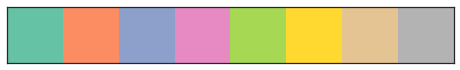

In [337]:
sns.palplot(sns.color_palette("Set2", len(fraction_of_negative_used)))

In [338]:
cmap = sns.color_palette("Set2", len(fraction_of_negative_used))

In [339]:
sns.color_palette("Set2", len(fraction_of_negative_used))

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [340]:
print(plt.style.available)

['grayscale', 'seaborn-ticks', 'seaborn', 'seaborn-deep', 'seaborn-white', 'ggplot', 'dark_background', 'seaborn-darkgrid', 'seaborn-colorblind', 'classic', 'fivethirtyeight', 'bmh', '_classic_test', 'seaborn-muted', 'seaborn-dark-palette', 'seaborn-paper', 'seaborn-pastel', 'seaborn-talk', 'seaborn-notebook', 'seaborn-poster', 'seaborn-bright', 'seaborn-whitegrid', 'seaborn-dark']


In [341]:
def plot_for_comparison(metrics_dict, ylabel="PR AUC", y_lim=(0.3, 1.0), cmap=None):
    plt.style.use('seaborn-white')
    plt.figure(figsize=(16, 7))
    for i, name in enumerate(metrics_dict.keys()):
        x, y = list(map(list, zip(*metrics_dict[name])))
        if cmap is not None:
            plt.plot(np.arange(len(x))/len(x), y, label=name, color=cmap[i%len(cmap)])
        else:
            plt.plot(np.arange(len(x))/len(x), y, label=name)
        plt.xticks(np.arange(len(x))/len(x), x)
    
    plt.ylabel(ylabel)
    plt.ylim(y_lim)
    plt.xlabel("% of used anomalies")
    plt.xlim(0, 1)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

#### PR AUC

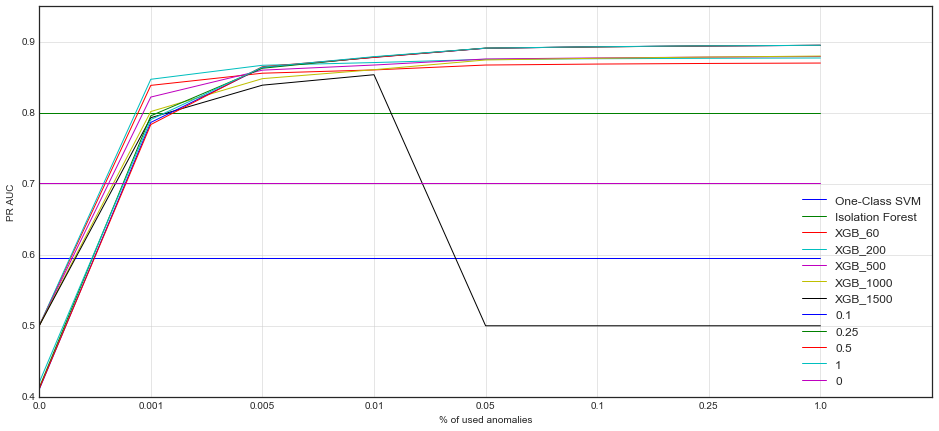

In [348]:
plot_for_comparison(pr_s, ylabel="PR AUC", y_lim=(0.4, 0.95), cmap=None)

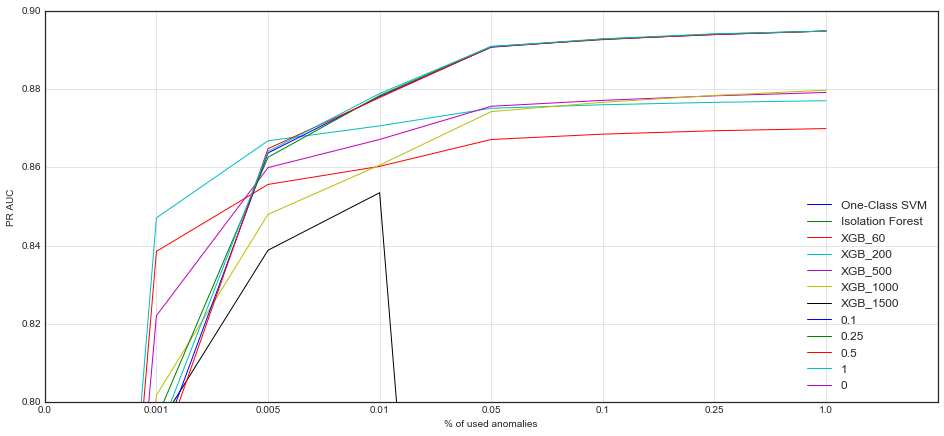

In [349]:
plot_for_comparison(pr_s, ylabel="PR AUC", y_lim=(0.8, 0.9), cmap=None)

#### ROC AUC

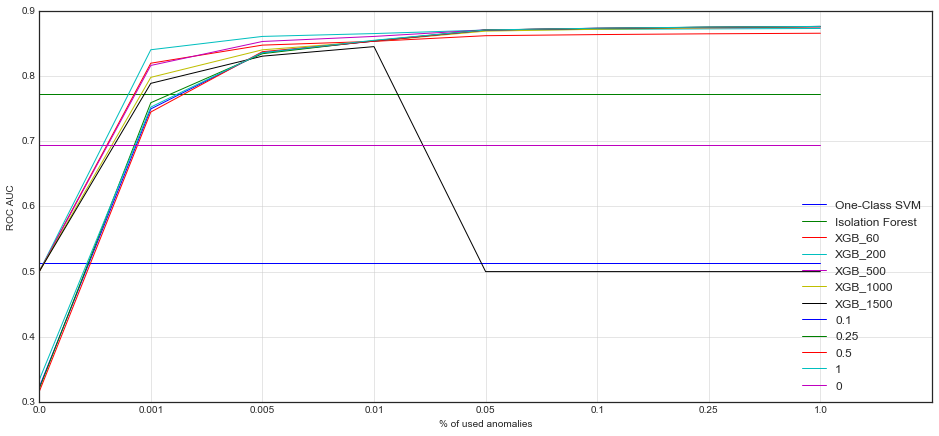

In [350]:
plot_for_comparison(roc_s, ylabel="ROC AUC", y_lim=(0.3, 0.9), cmap=None)

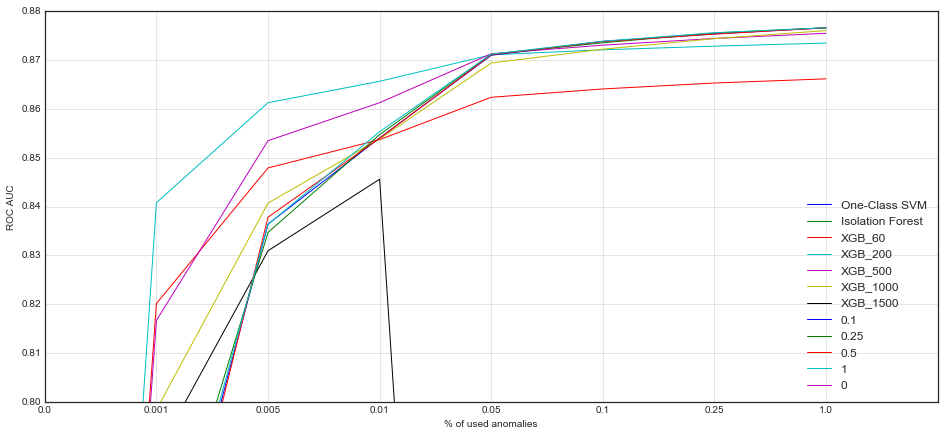

In [351]:
plot_for_comparison(roc_s, ylabel="ROC AUC", y_lim=(0.8, 0.88), cmap=None)

#### Precision at n

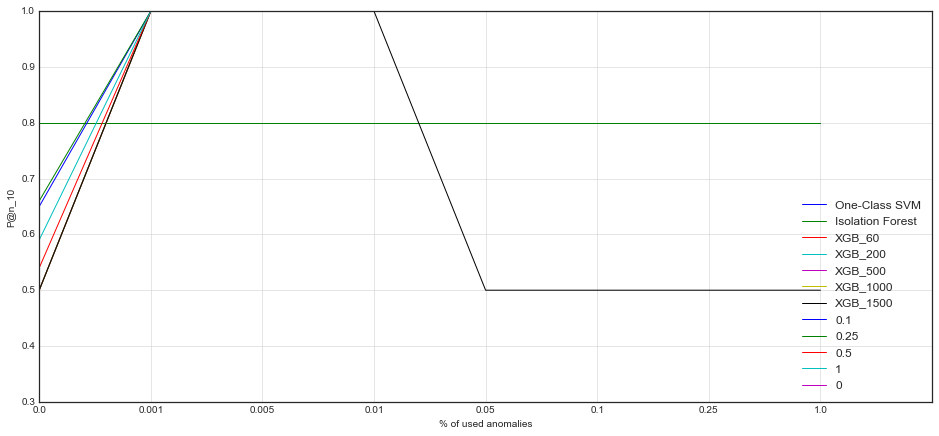

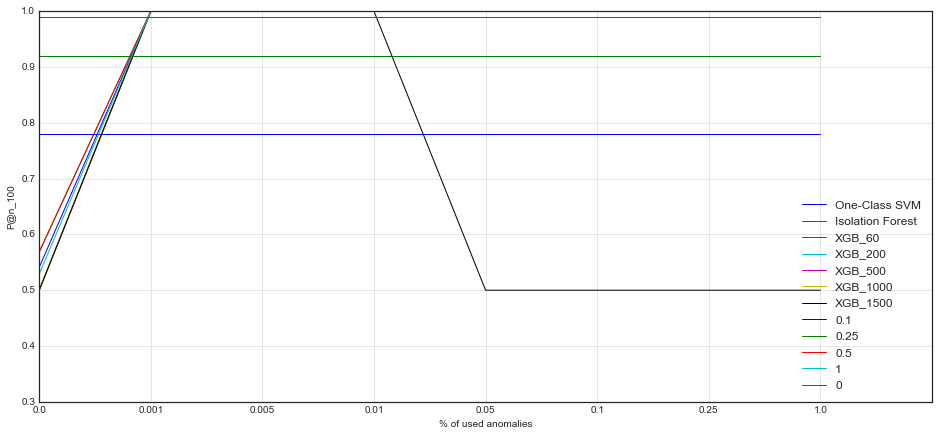

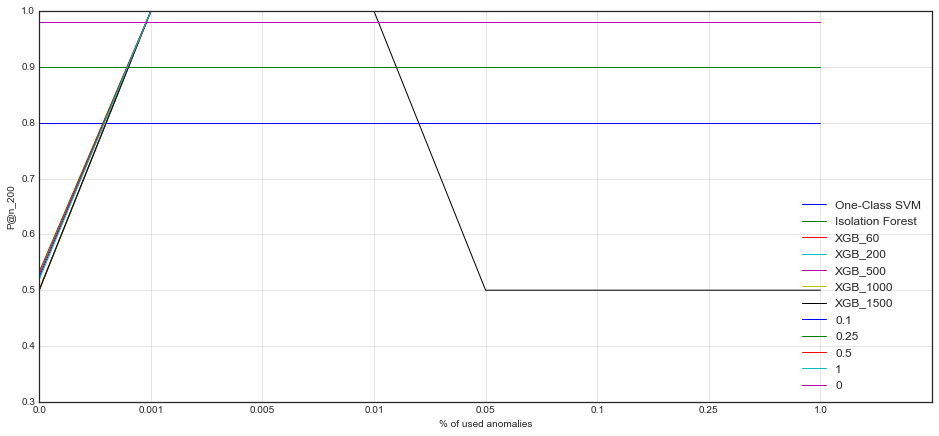

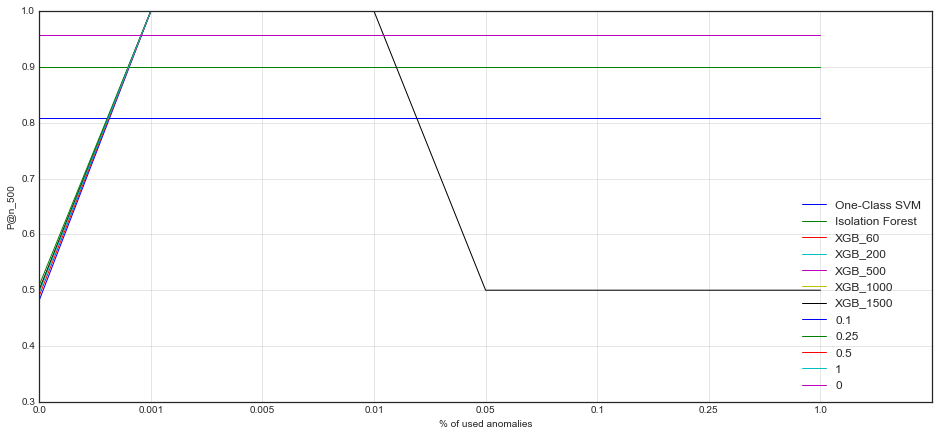

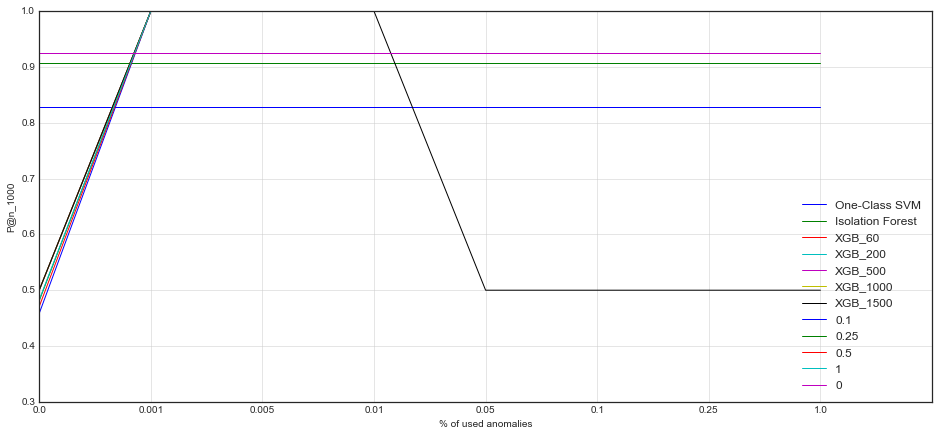

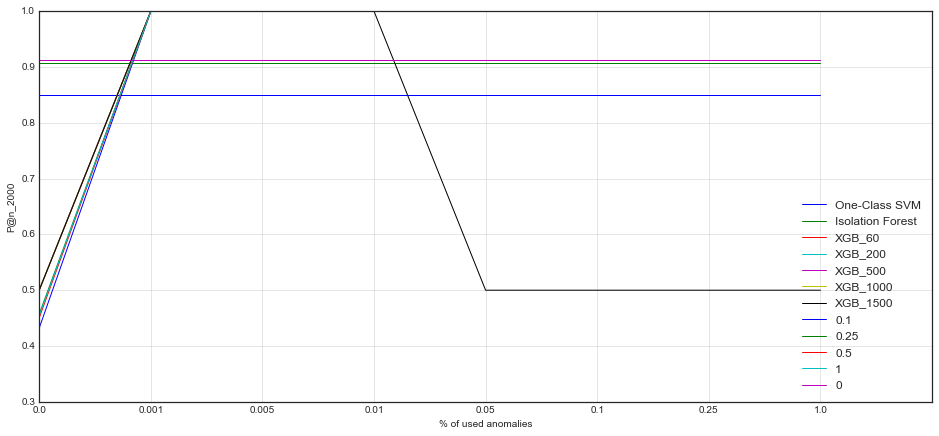

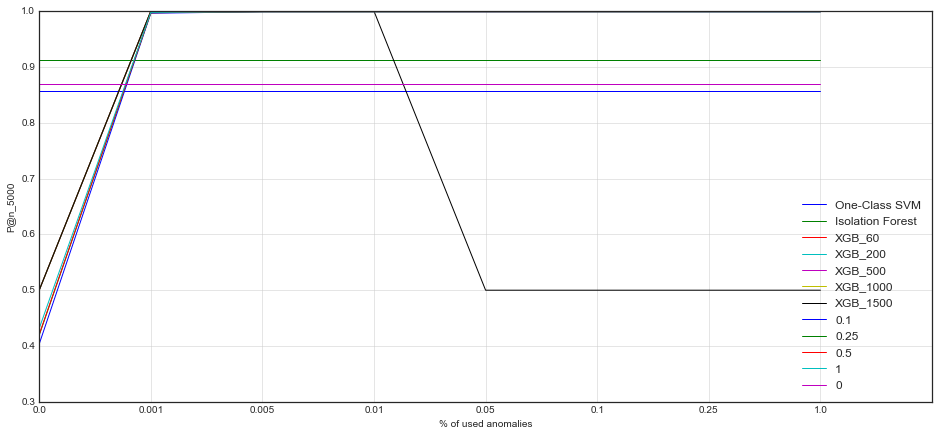

In [352]:
for key in p_at_n_s.keys():
    plot_for_comparison(p_at_n_s[key], ylabel="P@n_" + str(key), y_lim=(0.3, 1.0), cmap=None)

#### Precision at recall

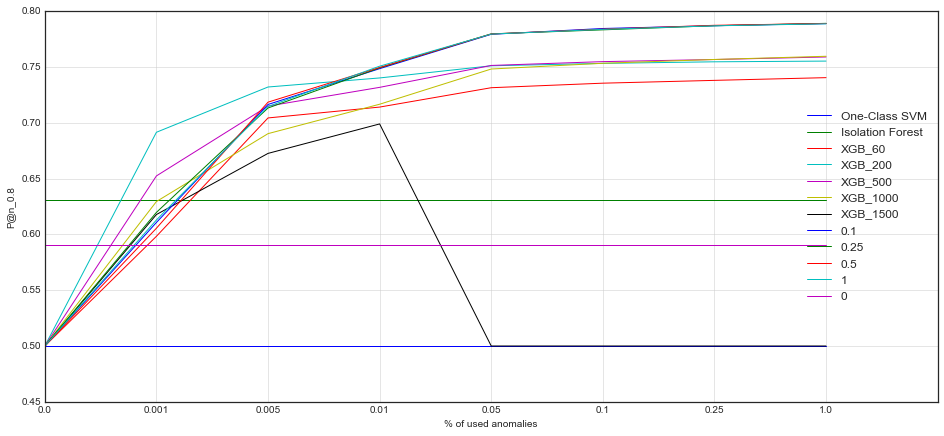

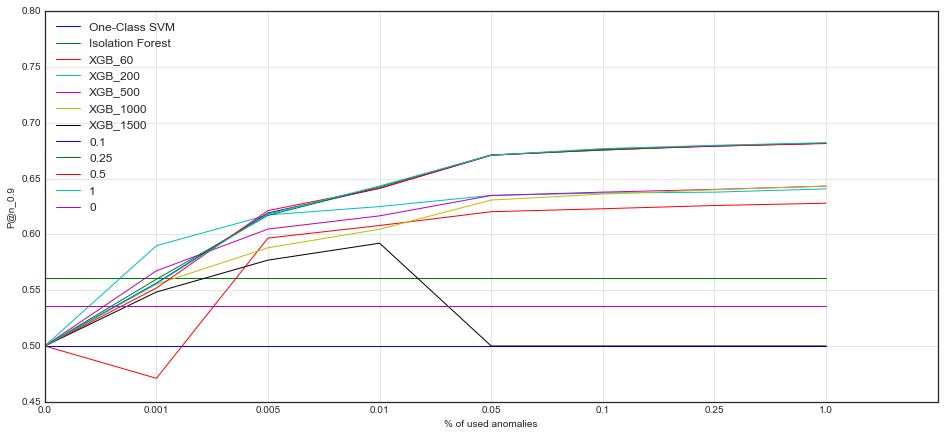

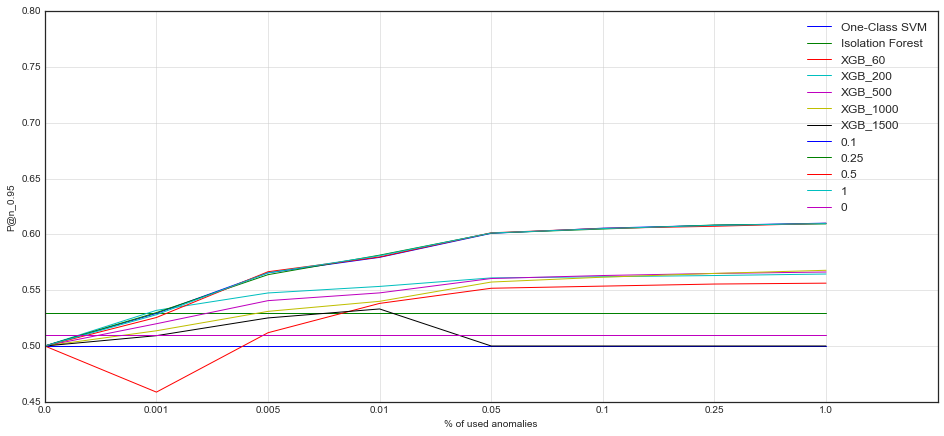

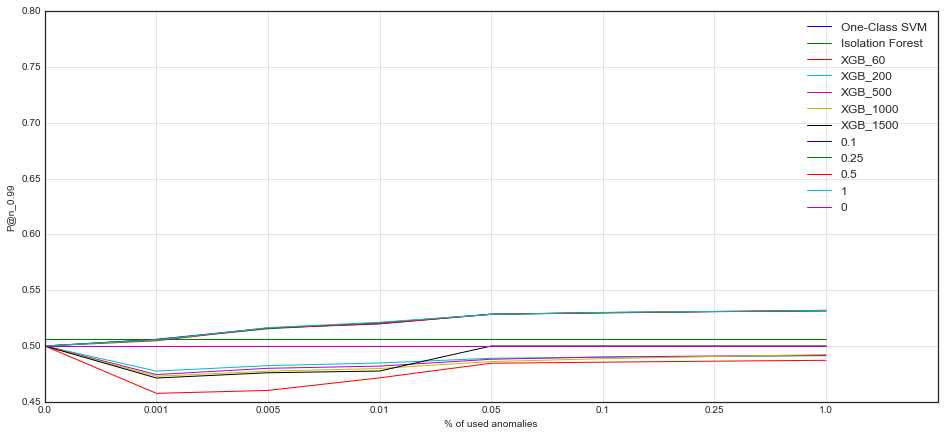

In [353]:
for key in p_at_r_s.keys():
    plot_for_comparison(p_at_r_s[key], ylabel="P@n_" + str(key), y_lim=(0.45, 0.8), cmap=None)